<a href="https://colab.research.google.com/github/Priyanka-Police-Reddy-Gari/CreditRisk_ML/blob/main/xgboost_aml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Modeling (ML Project using XGBoost)

### Summary of the notebook:
1. Download data from https://www.kaggle.com/competitions/amex-default-prediction/data. We will work with “train_data.csv” and “train_labels.csv”.
2. Read the train_data.csv and labels to a single dataframe, 20% of the data and randomly selected 20% of the data respectively.
3. Explore the data. Data Size, data type of features, a snapshot of data.
4. Perform One-Hot encoding on categorical variables.
5. Define some features. As mentioned, we have historical data for up to 13 months for each applicant. For some applicants less than that. We need to aggregate these up to 13 months.
6. Split data into 70% as Train sample, 15% as Test1, and 15% as Test2.
7. Reduce number of features, and keep only features which have high predictive power. To do so we build an XGB model and will keep features with Feature Importance higher than 0.5%.

    Make sure all missing values are stored as NaN, so XGBoost can work with them.
8. Run an XGBoost model on the train sample, with default parameters. Don’t forget to drop unnecessary columns if any. Calculate feature importance and save the feature importance as a CSV file.
9. Run another XGBoost model, which has 300 trees, 0.5 as learning rate, maximum depth of trees is 4, uses 50% of observation to build each tree, uses 50% of features to build each tree, and assigns a weight of 5 to default observations. Save the feature importance as a CSV file.
10. Keep features that have feature importance of higher 0.5% in any of the two models. We will use only these features after this.
11. Next we run Grid Search for the XGBoost model (using only features we chose in step 10). Use the following combinations in the grid search:
    - Number of trees: 50, 100, and 300
    - Learning Rate: 0.01, 0.1
    - Percentage of observations used in each tree: 50%, 80%
    - Percentage of features used in each tree: 50%, 100%
    - Weight of default observations: 1, 5, 10
    
    
    Create the following table. Update the table after each iteration of grid search and save the table, so in case you got memory error or any other issues, you don’t need to re-run that part of Grid.

12. Choose the best model, based on bias and variance. Re-run the model with optimum parameters, and save the final XGB model.
13. Outlier treatment and Normalization.
14. Gridsearch on Neural Network:
    - Number of hidden layers: 2, 4
    - nodes in each hidden layer: 4, 6
    - Activation function for hidden layers: ReLu, Tanh
    - Dropout regularization for hidden layers: 50%, 100% (no dropout)
    - Batch size: 100, 10000
    
15. Choose the best model, based on bias and variance. Re-run the model with optimum parameters, and save the final NN model.
16. Choose the best model among NN and XGB (models of step 11 and step 14)

> ***Monthly Revenue for 1 Customer= B_Ave×0.02+S_Ave×0.001***

17. Write a function that calculates default rate and revenue based on a threshold. Function gets six inputs:
    - Data with four columns: Target Variable (Default indicator), Default model’s output (PD), Estimated Monthly Balance, Estimated Monthly Spend
    - Name of Target Variable (as a text/string)
    - Name of default model’s output (as a text/string)
    - Name of Estimated Monthly Balance variable (as a text/string)
    - Name of Estimated Monthly Spend variable (as a text/string)
    - Threshold (a number between 0 and 1)



In [ ]:
# Imports
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from keras.layers import Dense
import tensorflow.keras as keras
from keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd, numpy as np, os, xgboost as xgb, matplotlib.pyplot as plt, seaborn as sns

In [ ]:
counter, train_data = 0, "train_data.csv"
dir_path = r"/Users/nikhil/Desktop/UTD BA Course/Applied Machine Learning/aml_project"
data_filepath = r"/Users/nikhil/Desktop/UTD BA Course/Applied Machine Learning/aml_project/data"

In [ ]:
os.path.exists(data_filepath + os.sep + train_data)

True

In [ ]:
full_df = pd.read_csv(data_filepath + os.sep + train_data)
full_df_shape = full_df.shape
print("The full dataframe shape is: ", full_df.shape)
# (5531451, 190)

The full dataframe shape is:  (5531451, 190)


In [ ]:
full_df['S_2'] = pd.to_datetime(full_df['S_2'])
full_df.head(2)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217


In [ ]:
# Range of the date(s) when the data was collected
date_range_min = full_df['S_2'].min()
date_range_max = full_df['S_2'].max()
print("Minimum Date:", date_range_min)
print("Maximum Date:", date_range_max)

Minimum Date: 2017-03-01 00:00:00
Maximum Date: 2018-03-31 00:00:00


In [ ]:
nrows_var = int((20 * full_df_shape[0])/100)
# print("There are the no of rows needed to be loaded to the dataframe", nrows_var)

#### 2. Loading the data

In [ ]:
df = pd.read_csv(data_filepath + os.sep + train_data, nrows=nrows_var)  # selecting the first "n" no. of rows

In [ ]:
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827


In [ ]:
print("Shape of the dataframe", df.shape)

Shape of the dataframe (1106290, 190)


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
P_2,1097225.0,0.656335,0.244903,-4.210819e-01,0.480124,0.694617,0.864999,1.010000
D_39,1106290.0,0.153339,0.270733,1.228086e-08,0.004529,0.009056,0.236702,5.362196
B_1,1106290.0,0.124561,0.212675,-1.535724e+00,0.008834,0.031447,0.127110,1.324059
B_2,1105884.0,0.620545,0.401439,4.012278e-07,0.104215,0.814291,1.002348,1.010000
R_1,1106290.0,0.078454,0.225739,1.534223e-09,0.002897,0.005780,0.008654,3.006102
...,...,...,...,...,...,...,...,...
D_141,1086358.0,0.165172,0.348907,1.073346e-08,0.003038,0.006065,0.009093,1.253571
D_142,189646.0,0.392140,0.237357,-1.444070e-02,0.201038,0.383520,0.559922,2.091407
D_143,1086358.0,0.179449,0.379504,5.549692e-09,0.003030,0.006062,0.009084,1.010000
D_144,1098199.0,0.053442,0.185132,4.524265e-08,0.002749,0.005510,0.008268,1.343316


In [ ]:
labels = pd.read_csv(data_filepath + os.sep + "train_labels.csv")
labels = labels.sample(frac=0.2, random_state=42)
labels.shape

(91783, 2)

In [ ]:
df = pd.merge(df, labels, on=["customer_ID"])
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,...,NaN,NaN,0.008263,0.006609,0.007370,NaN,0.007171,0.005120,0.007513,0
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,...,NaN,NaN,0.001986,0.004050,0.000796,NaN,0.001802,0.002364,0.003987,0
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,...,NaN,NaN,0.009515,0.008757,0.009219,NaN,0.003134,0.001686,0.001265,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,...,NaN,NaN,0.002524,0.007841,0.007421,NaN,0.000728,0.003591,0.007998,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,...,NaN,NaN,0.003823,0.009599,0.006957,NaN,0.008746,0.007101,0.006658,0


In [ ]:
df['S_2'] = pd.to_datetime(df['S_2'])  # coverting the "S_2" col dtype to datetime

In [ ]:
# customer_data = df.groupby('customer_ID')['target'].agg(['count', 'mean']).reset_index()
# customer_data.columns = ['customer_ID', 'Months_of_Data', 'Default_Rate']
# customer_data['Default_Rate'] = customer_data['Default_Rate'] * 100
# customer_count_by_months = customer_data['Months_of_Data'].value_counts().reset_index()
# customer_count_by_months.columns = ['Months_of_Data', 'Customer_Count']
# customer_count_by_months = customer_count_by_months.sort_values(by='Months_of_Data')
# print(customer_count_by_months)


# results_df = pd.DataFrame(columns=['Months', 'Observations', 'Default Rate', 'Default Rate Percentage'])
# for months_range in range(1, 14):
#     start_date = date_range_max - pd.DateOffset(months=months_range - 1)
#     filtered_df = full_df[full_df['S_2'] >= start_date]
#     num_observations = len(filtered_df)
#     num_defaults = len(filtered_df[filtered_df['target'] == 1])
#     default_rate = num_defaults / num_observations
#     default_rate_percentage = default_rate * 100
#     results_df = results_df.append({'Months': months_range, 'Observations': num_observations,
#                                     'Default Rate': default_rate, 'Default Rate Percentage': default_rate_percentage},
#                                    ignore_index=True)

# print(results_df)

# ------

# df['S_2'] = pd.to_datetime(df['S_2'])
# end_date = pd.to_datetime('2018-03-31')

# counts_by_month = {}
# default_rates_by_month = {}


# current_date = end_date
# month_number = 1

# while current_date >= pd.to_datetime('2017-03-01'):
#     start_date = current_date - pd.DateOffset(months=1)
#     customers_for_month = df[(df['S_2'] >= start_date) & (df['S_2'] <= current_date)]
#     unique_customer_ids_month = customers_for_month['customer_ID'].unique()
#     records_before_month = df[df['S_2'] < start_date]
#     unique_customer_ids_before_month = records_before_month['customer_ID'].unique()
#     unique_customer_ids_only_in_month = set(unique_customer_ids_month) - set(unique_customer_ids_before_month)
#     default_rate = customers_for_month[customers_for_month['customer_ID'].isin(unique_customer_ids_only_in_month)]['target'].mean()
#     month_label = current_date.strftime("%B %Y")
#     counts_by_month[month_label] = len(unique_customer_ids_only_in_month)
#     default_rates_by_month[month_label] = default_rate
#     print(month_number, counts_by_month[month_label], default_rates_by_month[month_label])
#     month_number = month_number + 1
#     current_date -= pd.DateOffset(months=1)

#### 3. Exploring the data size, data-types and shape of the dataframe

In [ ]:
# There are 5 types of features in this dataset
print("B -- ", len([i for i in df.columns if i.startswith("B")]))
print("D -- ", len([i for i in df.columns if i.startswith("D")]))
print("P -- ", len([i for i in df.columns if i.startswith("P")]))
print("R -- ", len([i for i in df.columns if i.startswith("R")]))
print("S -- ", len([i for i in df.columns if i.startswith("S")]))

B --  40
D --  96
P --  3
R --  28
S --  22


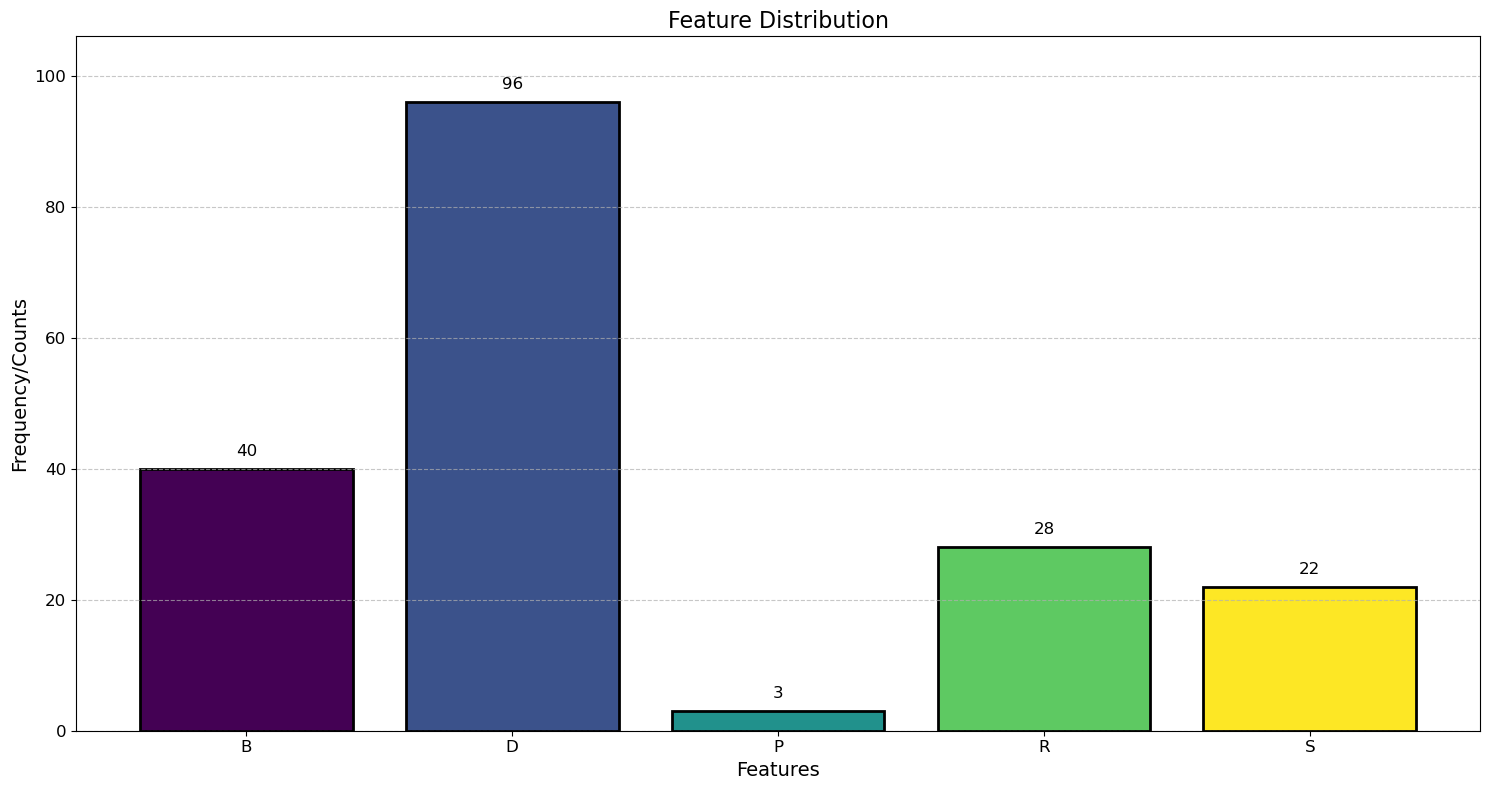

In [ ]:
# From above output
categories = ['B', 'D', 'P', 'R', 'S']
cat_count_values = [40, 96, 3, 28, 22]
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(categories)))
plt.figure(figsize=(15, 8))
plt.bar(categories, cat_count_values, color=colors, edgecolor='black', linewidth=2)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Frequency/Counts', fontsize=14)
plt.title('Feature Distribution', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for i, v in enumerate(cat_count_values):
    plt.text(i, v + 2, str(v), ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(cat_count_values) + 10)
plt.tight_layout()
plt.show()

In [ ]:
print("Shape of the dataframe", df.shape)
# here we can see an extra col called target

Shape of the dataframe (221426, 191)


In [ ]:
df.describe().T  # described the five point summary of the dataframe

,count,mean,min,25%,50%,75%,max,std
S_2,221426,2017-09-20 20:23:07.674437632,2017-03-01 00:00:00,2017-06-15 00:00:00,2017-09-23 00:00:00,2017-12-29 00:00:00,2018-03-31 00:00:00,NaN
P_2,219680.0,0.6558,-0.383019,0.480504,0.695774,0.864273,1.009998,0.245788
D_39,221426.0,0.153521,0.0,0.004528,0.009058,0.236797,5.362196,0.271862
B_1,221426.0,0.124921,-1.535724,0.008837,0.031418,0.127621,1.324051,0.213149
B_2,221342.0,0.621192,0.0,0.103717,0.814335,1.002406,1.01,0.401692
...,...,...,...,...,...,...,...,...
D_142,37836.0,0.39137,-0.014441,0.204723,0.381373,0.559856,2.091407,0.238123
D_143,217479.0,0.178817,0.0,0.003028,0.006065,0.009082,1.01,0.378956
D_144,219793.0,0.053557,0.0,0.002754,0.005511,0.008272,1.343316,0.186581
D_145,217479.0,0.061515,0.0,0.003024,0.006041,0.009087,4.82763,0.197525


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221426 entries, 0 to 221425
Columns: 191 entries, customer_ID to target
dtypes: datetime64[ns](1), float64(185), int64(2), object(3)
memory usage: 322.7+ MB


In [ ]:
# Unique dtypes
set(df.dtypes)

{dtype('int64'), dtype('float64'), dtype('<M8[ns]'), dtype('O')}

In [ ]:
# datatypes
df_dtypes = df.dtypes.reset_index()
df_dtypes

,index,0
0,customer_ID,object
1,S_2,datetime64[ns]
2,P_2,float64
3,D_39,float64
4,B_1,float64
...,...,...
186,D_142,float64
187,D_143,float64
188,D_144,float64
189,D_145,float64


In [ ]:
# Snapshot of the data
counter = counter + 1
df_dtypes.columns = ['Columns', "Data Type"]
df_dtypes.to_csv(dir_path + os.sep + "{}_data_types.csv".format(counter), index=False)

In [ ]:
counter = counter + 1
df.to_csv(dir_path + os.sep + "{}_credit_risk_train_data.csv".format(counter)) #, index=False)

#### 4. One-hot encoding

In [ ]:
df.dtypes[df.dtypes == "object"]

customer_ID    object
D_63           object
D_64           object
dtype: object

In [ ]:
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,...,NaN,NaN,0.008263,0.006609,0.007370,NaN,0.007171,0.005120,0.007513,0
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,...,NaN,NaN,0.001986,0.004050,0.000796,NaN,0.001802,0.002364,0.003987,0
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,...,NaN,NaN,0.009515,0.008757,0.009219,NaN,0.003134,0.001686,0.001265,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,...,NaN,NaN,0.002524,0.007841,0.007421,NaN,0.000728,0.003591,0.007998,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,...,NaN,NaN,0.003823,0.009599,0.006957,NaN,0.008746,0.007101,0.006658,0


In [ ]:
df['customer_ID'][df['customer_ID'].duplicated()]

1         000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...
2         000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...
3         000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...
4         000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...
5         000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...
                                ...                        
221420    331a194f2698d672eefb5938b421d7e2bd5a7dfab00921...
221421    331a194f2698d672eefb5938b421d7e2bd5a7dfab00921...
221422    331a194f2698d672eefb5938b421d7e2bd5a7dfab00921...
221423    331a194f2698d672eefb5938b421d7e2bd5a7dfab00921...
221424    331a194f2698d672eefb5938b421d7e2bd5a7dfab00921...
Name: customer_ID, Length: 203076, dtype: object

In [ ]:
object_list = ["D_63", "D_64"]

# object list from the website:
# ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',
#  'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

categorical_columns = ['B_30', 'B_38', 'D_114',
                       'D_116', 'D_117', 'D_120',
                       'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

object_list = sorted(list(set(object_list + categorical_columns)))
print(object_list)

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221426 entries, 0 to 221425
Columns: 191 entries, customer_ID to target
dtypes: datetime64[ns](1), float64(185), int64(2), object(3)
memory usage: 324.4+ MB


In [ ]:
df.select_dtypes(include=['uint8']).columns.tolist()

[]

In [ ]:
for i in object_list:
    df = pd.get_dummies(df, columns=[i], prefix=[i])

df.dtypes[df.dtypes == "object"]  # customer_ID and S_2 should not be one-hot encoded

customer_ID    object
dtype: object

In [ ]:
len(df.select_dtypes(include=['uint8']).columns.tolist())

45

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221426 entries, 0 to 221425
Columns: 225 entries, customer_ID to D_68_6.0
dtypes: datetime64[ns](1), float64(176), int64(2), object(1), uint8(45)
memory usage: 315.3+ MB


#### 5. Feature Engineering

In [ ]:
# Adding mean, min, max and std values as a new col
b_filtered_columns = [col for col in df.columns
                      if col.startswith("B") and col not in categorical_columns]
d_filtered_columns = [col for col in df.columns
                      if col.startswith("D") and col not in categorical_columns]
p_filtered_columns = [col for col in df.columns
                      if col.startswith("P") and col not in categorical_columns]
s_filtered_columns = [col for col in df.columns
                      if col.startswith("S") and col not in categorical_columns]
r_filtered_columns = [col for col in df.columns
                      if col.startswith("R") and col not in categorical_columns]

df['B_avg'] = df[b_filtered_columns].mean(axis=1)
df['D_avg'] = df[d_filtered_columns].mean(axis=1)
df['P_avg'] = df[p_filtered_columns].mean(axis=1)
df['S_avg'] = df[s_filtered_columns].mean(axis=1)
df['R_avg'] = df[r_filtered_columns].mean(axis=1)

# ----

df['B_min'] = df[b_filtered_columns].min(axis=1)
df['D_min'] = df[d_filtered_columns].min(axis=1)
df['P_min'] = df[p_filtered_columns].min(axis=1)
df['S_min'] = df[s_filtered_columns].min(axis=1)
df['R_min'] = df[r_filtered_columns].min(axis=1)

# ----

df['B_max'] = df[b_filtered_columns].max(axis=1)
df['D_max'] = df[d_filtered_columns].max(axis=1)
df['P_max'] = df[p_filtered_columns].max(axis=1)
df['S_max'] = df[s_filtered_columns].max(axis=1)
df['R_max'] = df[r_filtered_columns].max(axis=1)

# ----

df['B_std'] = df[b_filtered_columns].std(axis=1)
df['D_std'] = df[d_filtered_columns].std(axis=1)
df['P_std'] = df[p_filtered_columns].std(axis=1)
df['S_std'] = df[s_filtered_columns].std(axis=1)
df['R_std'] = df[r_filtered_columns].std(axis=1)

# ----

df['B_sum'] = df[b_filtered_columns].sum(axis=1)
df['D_sum'] = df[d_filtered_columns].sum(axis=1)
df['P_sum'] = df[p_filtered_columns].sum(axis=1)
df['S_sum'] = df[s_filtered_columns].sum(axis=1)
df['R_sum'] = df[r_filtered_columns].sum(axis=1)

/var/folders/s7/45zxppwj6wb8hl7_80_fr0cm0000gn/T/ipykernel_13046/1584003767.py:15: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df['S_avg'] = df[s_filtered_columns].mean(axis=1)
/var/folders/s7/45zxppwj6wb8hl7_80_fr0cm0000gn/T/ipykernel_13046/1584003767.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['S_min'] = df[s_filtered_columns].min(axis=1)
/var/folders/s7/45zxppwj6wb8hl7_80_fr0cm0000gn/T/ipykernel_13046/1584003767.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['S_max'] = df[s_filtered_columns].max(axis=1)
/var/folders/s7/45zxppwj6

In [ ]:
len([i for i in df.columns if i.startswith("R")])
df.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,B_std,D_std,P_std,S_std,R_std,B_sum,D_sum,P_sum,S_sum,R_sum
count,219680.000000,2.214260e+05,221426.000000,2.213420e+05,2.214260e+05,180211.000000,2.213420e+05,2.213420e+05,31358.000000,155864.000000,...,221426.000000,221426.000000,219922.000000,221426.000000,221426.000000,221426.000000,221426.000000,221426.000000,221426.000000,221426.000000
mean,0.655800,1.535208e-01,0.124921,6.211917e-01,7.910840e-02,0.224525,6.035353e-02,1.338110e-01,0.184753,0.154009,...,0.377539,0.368254,0.378801,0.365978,0.339887,9.150184,21.478374,1.362987,5.318353,2.974466
std,0.245788,2.718624e-01,0.213149,4.016923e-01,2.280379e-01,0.192625,2.027752e-01,2.371744e-01,0.237786,0.209152,...,0.638090,0.368857,0.100915,0.546079,1.601393,5.779523,6.425961,0.405687,2.926590,9.092148
min,-0.383019,1.323593e-07,-1.535724,4.012278e-07,2.962930e-08,-0.347854,4.056451e-08,4.135339e-07,-0.000129,0.000002,...,0.245484,0.136822,0.000183,0.194232,0.003178,3.382337,1.596344,-1.460591,-169.770436,0.062840
25%,0.480504,4.527764e-03,0.008837,1.037166e-01,2.883749e-03,0.126969,2.891373e-03,5.221427e-03,0.034919,0.041863,...,0.329940,0.338649,0.319717,0.327760,0.271146,7.052897,18.136118,1.158381,3.870314,2.124339
50%,0.695774,9.058442e-03,0.031418,8.143346e-01,5.761964e-03,0.163664,5.758607e-03,9.749214e-03,0.120340,0.087582,...,0.342725,0.356444,0.394585,0.340026,0.271882,8.047526,21.168131,1.405767,5.347023,2.153395
75%,0.864273,2.367966e-01,0.127621,1.002406e+00,8.641052e-03,0.255529,8.635633e-03,1.562837e-01,0.246041,0.184488,...,0.362302,0.375081,0.453664,0.364276,0.274055,10.124009,24.456322,1.577144,6.251900,2.435679
max,1.009998,5.362196e+00,1.324051,1.010000e+00,3.006102e+00,2.543488,5.231620e+00,1.573556e+00,4.186889,5.768021,...,111.692301,46.476319,1.215924,141.591674,247.735518,756.584990,492.142940,3.440194,496.719221,1300.370941


In [ ]:
# numerical_features, months_to_agg = [col for col in df.columns if col not in categorical_columns], [12, 9, 6, 3]

# for feature in numerical_features:
#     for num_months in months_to_agg:
#         df[f'{feature}_Ave_{num_months}'] = df.groupby('customer_ID')[feature].rolling(num_months).mean().reset_index(0, drop=True)
#         df[f'{feature}_Min_{num_months}'] = df.groupby('customer_ID')[feature].rolling(num_months).min().reset_index(0, drop=True)
#         df[f'{feature}_Max_{num_months}'] = df.groupby('customer_ID')[feature].rolling(num_months).max().reset_index(0, drop=True)
#         df[f'{feature}_Sum_{num_months}'] = df.groupby('customer_ID')[feature].rolling(num_months).sum().reset_index(0, drop=True)
#     df[f'{feature}_Apr_2018'] = df[df['date_column'] == '2018-04-01'][feature]
#     df[f'{feature}_You_Name_It'] = (df[f'{feature}_Apr_2018'] - df[f'{feature}_Apr_2017']) / df[f'{feature}_Apr_2017']

# for feature in categorical_columns:
#     for num_months in months_to_agg:
#         df[f'{feature}_Response_Rate_{num_months}'] = df.groupby('customer_ID')[feature].rolling(num_months).mean().reset_index(0, drop=True)
#     df[f'{feature}_Ever_Response_12'] = df.groupby('customer_ID')[feature].rolling(12).sum().reset_index(0, drop=True) > 0

# one_hot_encoded_categorical_features = ['D_66_0.0', 'D_66_1.0', 'D_126_-1.0', ...]

# for feature in one_hot_encoded_categorical_features:
#     for num_months in months_to_agg:
#         df[f'{feature}_Response_Rate_{num_months}'] = df.groupby('customer_ID')[feature].rolling(num_months).mean().reset_index(0, drop=True)
#     df[f'{feature}_Ever_Response_12'] = df.groupby('customer_ID')[feature].rolling(12).sum().reset_index(0, drop=True) > 0

In [ ]:
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,B_std,D_std,P_std,S_std,R_std,B_sum,D_sum,P_sum,S_sum,R_sum
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,...,0.353781,0.251551,0.417275,0.368895,0.274321,7.967862,8.121480,1.339328,5.931268,2.419159
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,...,0.296243,0.247897,0.385785,0.335777,0.272443,5.992664,8.255267,1.374120,4.850009,2.345141
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,...,0.294156,0.340692,0.386194,0.336025,0.271952,6.205873,16.873180,1.372781,4.737184,2.307919
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,...,0.292319,0.347709,0.447665,0.343451,0.289012,5.997824,17.926093,1.291061,4.799127,3.018062
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,...,0.291230,0.345045,0.330173,0.335937,0.277869,6.159592,17.456140,1.460913,5.030786,2.557095


#### 6. Train-test-split(s)

In [ ]:
# We also remove features that are related to these plans,
# as we do not consider those observations for modeling.
df.drop(["customer_ID", "S_2"], axis = 1, inplace = True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[[i for i in df.columns if i not in ['target']]], df['target'], test_size=0.3, random_state=42)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
print("Training sample shape; ", X_train.shape)
print("Training target shape; ", y_train.shape)
print("Testing sample 1 shape; ", X_test1.shape)
print("Testing target 1 shape; ", y_test1.shape)
print("Testing sample 1 shape; ", X_test2.shape)
print("Testing target 1 shape; ", y_test2.shape)

Training sample shape;  (154998, 247)
Training target shape;  (154998,)
Testing sample 1 shape;  (33214, 247)
Testing target 1 shape;  (33214,)
Testing sample 1 shape;  (33214, 247)
Testing target 1 shape;  (33214,)


#### Feature importance can be figured out using corr()

In [ ]:
# Eliminating the features based on corr and Feature Importance
df.corr()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,B_std,D_std,P_std,S_std,R_std,B_sum,D_sum,P_sum,S_sum,R_sum
P_2,1.000000,-0.192216,-0.368846,0.542109,-0.468627,-0.339157,-0.326129,-0.455487,-0.435943,-0.307279,...,-0.021309,-0.047344,0.610699,-0.024925,-0.088617,-0.223442,-0.195293,0.593987,-0.083968,-0.161523
D_39,-0.192216,1.000000,0.182350,-0.196588,0.192035,0.050779,0.453815,0.174246,0.053958,0.043948,...,0.035766,0.031776,-0.108630,0.025947,0.044441,0.133793,0.186004,-0.167041,0.143455,0.074773
B_1,-0.368846,0.182350,1.000000,-0.633864,0.226325,0.165190,0.190606,0.736044,-0.062506,0.069923,...,0.022603,0.011391,-0.294314,0.027851,0.038143,0.340754,0.152305,-0.254442,0.104163,0.064106
B_2,0.542109,-0.196588,-0.633864,1.000000,-0.305987,-0.237335,-0.260741,-0.714426,-0.076788,-0.141645,...,-0.008086,-0.017237,0.365075,-0.019662,-0.040549,-0.256019,-0.202681,0.310218,-0.047291,-0.079947
R_1,-0.468627,0.192035,0.226325,-0.305987,1.000000,0.206949,0.281217,0.278110,0.157505,0.187339,...,0.031467,0.039092,-0.246585,0.040826,0.159049,0.160747,0.218315,-0.359614,0.100525,0.293040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B_sum,-0.223442,0.133793,0.340754,-0.256019,0.160747,0.077751,0.155895,0.344634,-0.016089,0.063925,...,0.882463,0.026171,-0.165051,0.108713,0.025195,1.000000,0.142874,-0.169454,0.191929,0.043414
D_sum,-0.195293,0.186004,0.152305,-0.202681,0.218315,0.011535,0.158866,0.231151,0.091696,0.151197,...,0.021980,0.671256,-0.088139,0.005718,0.056628,0.142874,1.000000,-0.175369,0.071333,0.097557
P_sum,0.593987,-0.167041,-0.254442,0.310218,-0.359614,-0.104679,-0.285861,-0.367290,-0.291341,-0.136837,...,-0.021812,-0.041575,0.330922,-0.015669,-0.078143,-0.169454,-0.175369,1.000000,-0.020444,-0.134488
S_sum,-0.083968,0.143455,0.104163,-0.047291,0.100525,0.169117,0.052551,0.033326,0.014448,0.057931,...,0.103614,0.013143,-0.070686,0.324306,0.008500,0.191929,0.071333,-0.020444,1.000000,0.014863


<Axes: >

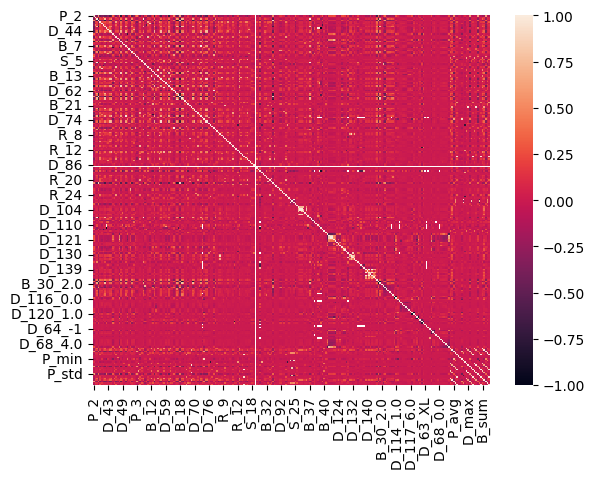

In [ ]:
import seaborn as sns
sns.heatmap(df.corr())

In [ ]:
correlation_matrix = df.corr()
mask = (correlation_matrix > 0.7) | (correlation_matrix < -0.7)  # mask for values > 0.7 or < -0.7
high_correlation_features = correlation_matrix[mask].stack().reset_index()
high_correlation_features.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_correlation_features = high_correlation_features[high_correlation_features['Feature 1'] != high_correlation_features['Feature 2']]
high_correlation_features.sort_values(['Correlation'], ascending=False)

,Feature 1,Feature 2,Correlation
299,D_110,D_42,1.000000
30,D_42,D_110,1.000000
31,D_42,D_111,1.000000
301,D_111,D_42,1.000000
119,D_62,D_77,0.999782
...,...,...,...
390,D_114_1.0,D_114_0.0,-0.936829
373,B_30_0.0,B_30_1.0,-0.959886
377,B_30_1.0,B_30_0.0,-0.959886
32,D_42,B_39,-1.000000


#### 7. Feature importance using XGB Classifier (feature importance)

In [ ]:
xgb_instance = xgb.XGBClassifier()
model_for_feature_selection = xgb_instance.fit(X_train, y_train)
model_for_feature_selection

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

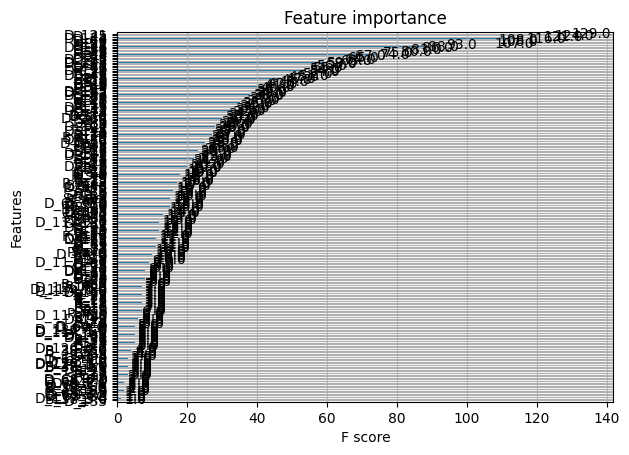

In [ ]:
xgb.plot_importance(model_for_feature_selection, importance_type='weight')

In [ ]:
feature_importance = {'Feature':X_train.columns, 'Importance':model_for_feature_selection.feature_importances_}
feature_importance = pd.DataFrame(feature_importance)
feature_importance.sort_values("Importance", inplace=True, ascending=False)
feature_importance

,Feature,Importance
0,P_2,0.176877
2,B_1,0.052751
24,B_9,0.022948
7,B_3,0.020055
246,R_sum,0.019607
...,...,...
101,D_87,0.000000
179,B_30_2.0,0.000000
190,D_116_1.0,0.000000
104,D_88,0.000000


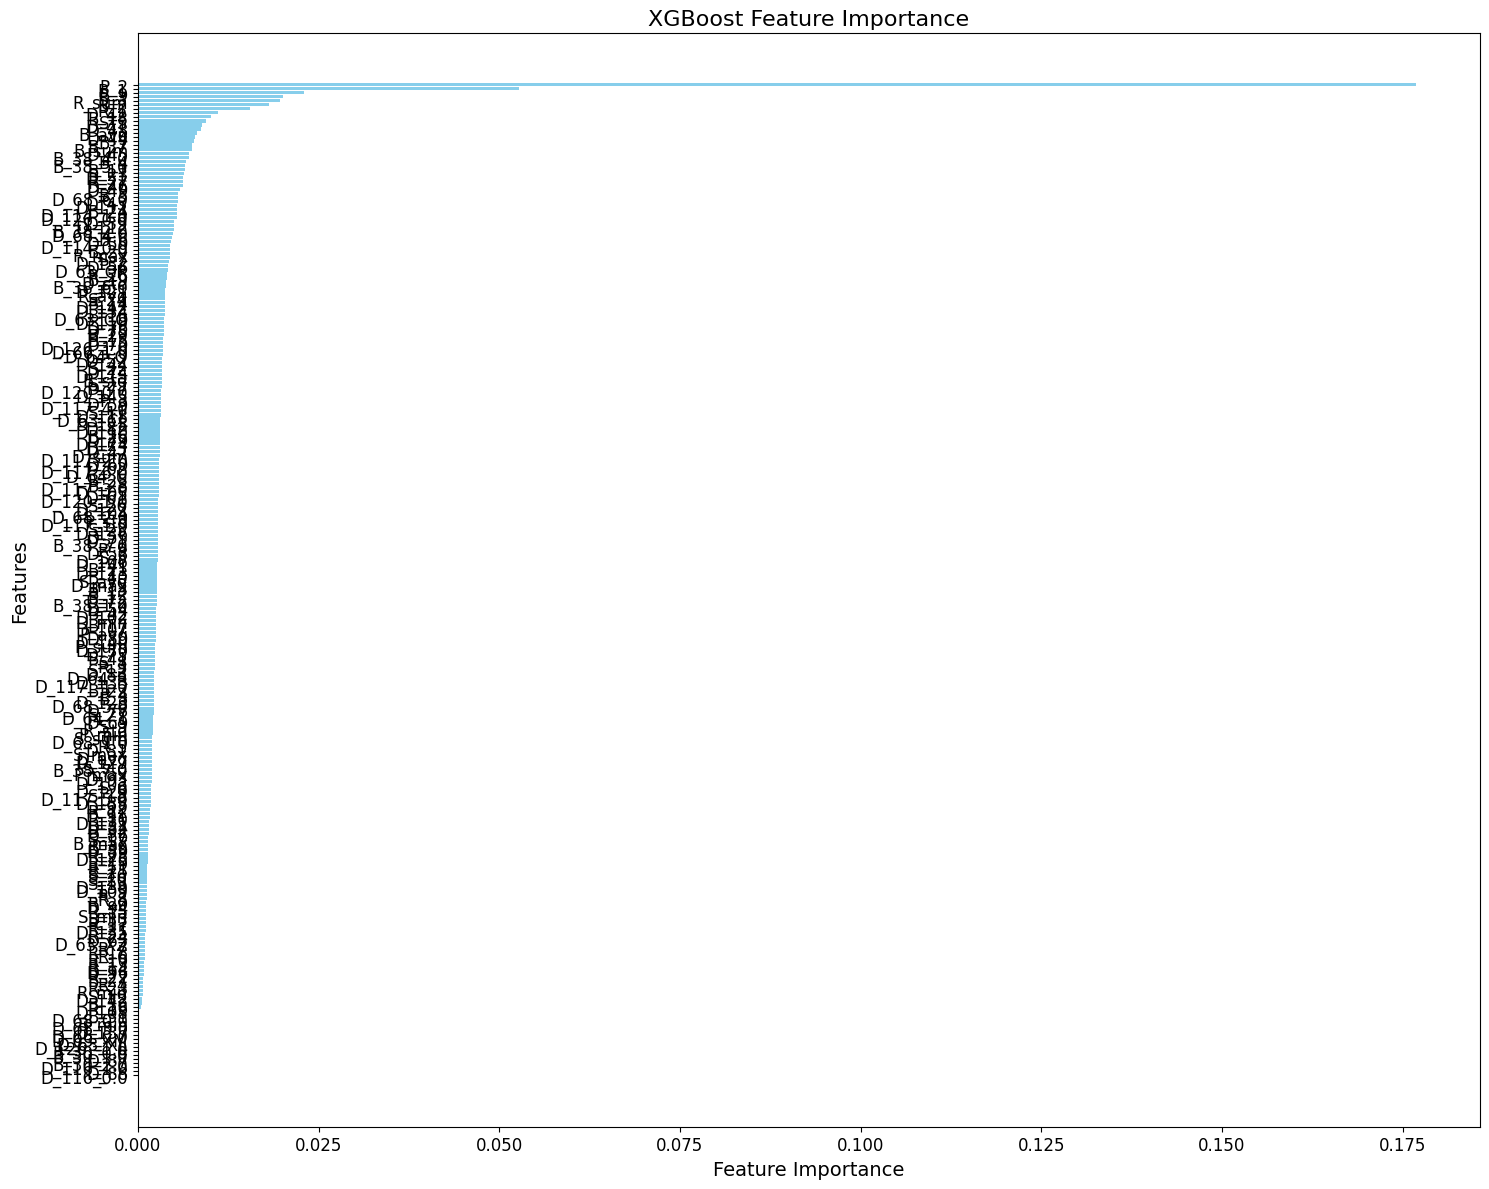

In [ ]:
plt.figure(figsize=(15, 12))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

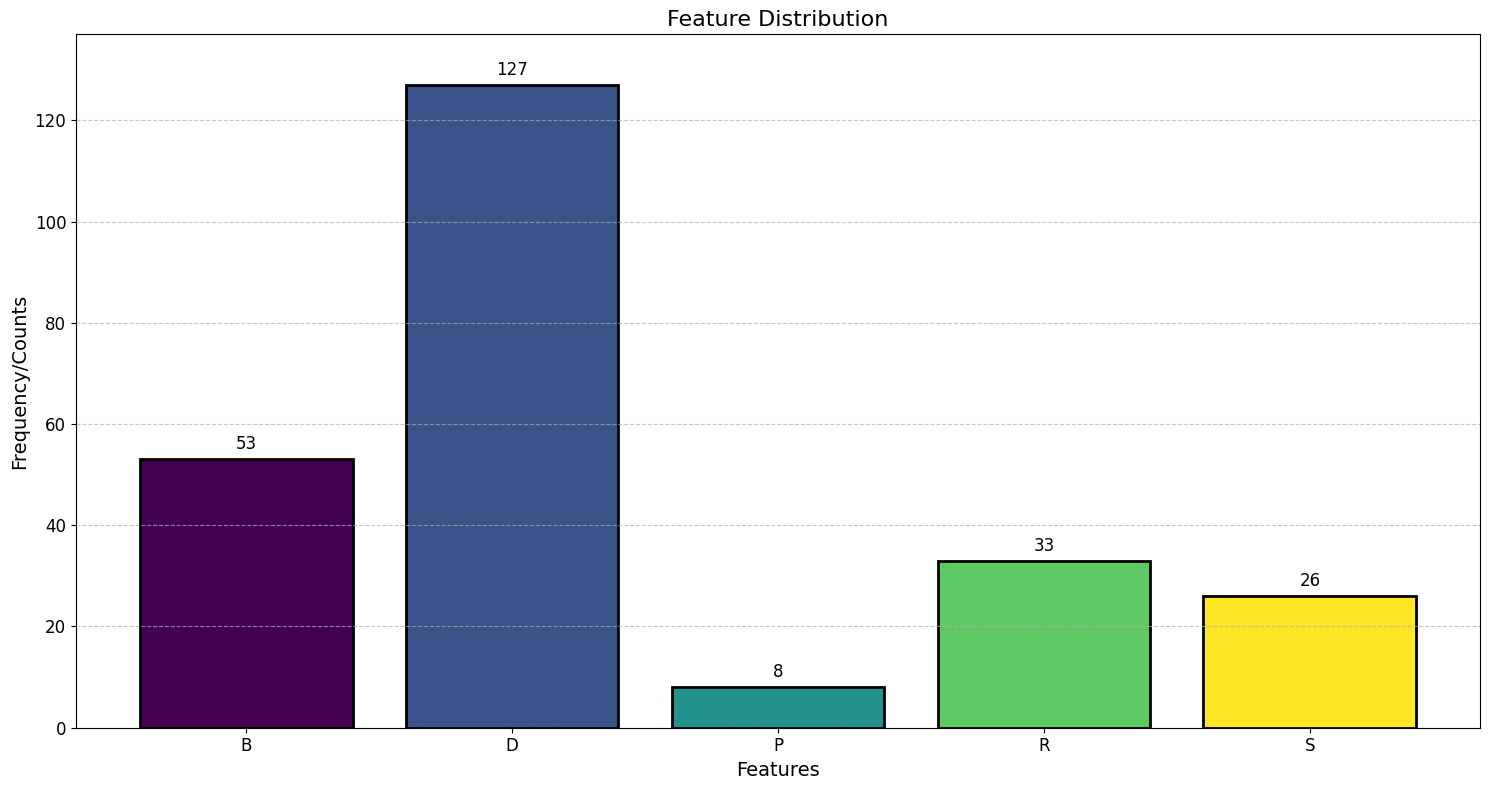

In [ ]:
categories = ['B', 'D', 'P', 'R', 'S']
cat_count_values = [len([i for i in X_train.columns if i.startswith("B")]),
                    len([i for i in X_train.columns if i.startswith("D")]),
                    len([i for i in X_train.columns if i.startswith("P")]),
                    len([i for i in X_train.columns if i.startswith("R")]),
                    len([i for i in X_train.columns if i.startswith("S")])]
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(categories)))
plt.figure(figsize=(15, 8))
plt.bar(categories, cat_count_values, color=colors, edgecolor='black', linewidth=2)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Frequency/Counts', fontsize=14)
plt.title('Feature Distribution', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for i, v in enumerate(cat_count_values):
    plt.text(i, v + 2, str(v), ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(cat_count_values) + 10)
plt.tight_layout()
plt.show()

In [ ]:
final_features = feature_importance["Feature"][feature_importance.Importance > 0.005]
X_train = X_train[final_features]
X_test1 = X_test1[final_features]
X_test2 = X_test2[final_features]

In [ ]:
print(X_train.shape)
print(X_test1.shape)
print(X_test2.shape)

(154998, 36)
(33214, 36)
(33214, 36)


Replacing NULL's with NaN's

In [ ]:
X_train.isnull().sum()[df.isnull().sum()>0].index
X_train.fillna(np.NaN, inplace=True)

#### 8. XGBoost model on the train sample, with default parameters

In [ ]:
xgb_instance = xgb.XGBClassifier()
updated_model_for_feature_selection = xgb_instance.fit(X_train, y_train)
feature_importance1 = {'Feature':X_train.columns, 'Importance':updated_model_for_feature_selection.feature_importances_}
feature_importance1 = pd.DataFrame(feature_importance1)
feature_importance1.sort_values("Importance", inplace=True, ascending=False)
counter = counter + 1
feature_importance1.to_csv(dir_path + os.sep + "{}_feature_importancev.csv".format(counter), index=False)
feature_importance1

,Feature,Importance
0,P_2,0.374492
1,B_1,0.075010
2,B_9,0.040392
3,B_3,0.030908
7,D_42,0.030097
9,S_3,0.021215
16,B_sum,0.020015
32,D_114_1.0,0.018461
19,B_4,0.018388
24,R_27,0.018344


#### 9. XGBoost model with specific params

In [ ]:
params = {
    'n_estimators': 300,  # no. of trees
    'learning_rate': 0.5,  # learning-rate
    'max_depth': 4,  # max depth
    'subsample': 0.5,  # fraction of observations to build each tree
    'colsample_bytree': 0.5,  # fraction of features to build each tree
    'scale_pos_weight': 5,  # weight of default observations
    'random_state': 42  # random seed
}

In [ ]:
xgb_instance = xgb.XGBClassifier(**params)
model_for_feature_selection = xgb_instance.fit(X_train, y_train)
feature_importance2 = {'Feature':X_train.columns,'Importance':model_for_feature_selection.feature_importances_}
feature_importance2 = pd.DataFrame(feature_importance2)
feature_importance2.sort_values("Importance", inplace=True, ascending=False)
counter = counter + 1
feature_importance2.to_csv(dir_path + os.sep + "{}_feature_importancev.csv".format(counter), index=False)
feature_importance2

,Feature,Importance
14,B_7,0.207795
0,P_2,0.127902
7,D_42,0.066422
13,D_44,0.048423
17,D_45,0.030952
32,D_114_1.0,0.030280
3,B_3,0.029026
9,S_3,0.023387
12,B_avg,0.022634
1,B_1,0.022137


#### 10. Keep features that have feature importance of higher 0.5% in any of the two models.

In [ ]:
# [i for i in feature_importance1['Feature'] if i not in feature_importance2['Feature']]

In [ ]:
final_features = feature_importance2["Feature"][feature_importance2.Importance > 0.005]
X_train = X_train[final_features]
X_test1 = X_test1[final_features]
X_test2 = X_test2[final_features]

#### 11. XGBoost Gridsearch

In [ ]:
# grid search
table = pd.DataFrame(columns = ["Num Trees", "Learning Rate",
                                "Percent of obs used in tree",
                                "Percent of features used in tree",
                                "Weight of def obs", "AUC Train",
                                "AUC Test1", "AUC Test2"])

row = 0

for trees in [50, 100, 300]:
    for lr in [0.01, 0.1]:
        for per_observations in [0.5, 0.8]:
            for feat_tree in [0.5, 1]:
                for weight in [1, 5, 10]:
                    xgb_instance = xgb.XGBClassifier(n_estimators= trees,
                                                    learning_rate= lr,
                                                    subsample= per_observations,
                                                    colsample_bytree= feat_tree,
                                                    scale_pos_weight= weight,
                                                    random_state= 42)
                    xg_iter_model = xgb_instance.fit(X_train, y_train)

                    table.loc[row,"Num Trees"] = trees
                    table.loc[row,"Learning Rate"] = lr
                    table.loc[row,"Percent of obs used in tree"] = per_observations
                    table.loc[row,"Percent of features used in tree"] = feat_tree
                    table.loc[row,"Weight of def obs"] = weight

                    table.loc[row,"AUC Train"] = roc_auc_score(y_train, xg_iter_model.predict_proba(X_train)[:,1])
                    table.loc[row,"AUC Test1"] = roc_auc_score(y_test1, xg_iter_model.predict_proba(X_test1)[:,1])
                    table.loc[row,"AUC Test2"] = roc_auc_score(y_test2, xg_iter_model.predict_proba(X_test2)[:,1])

                    row = row + 1
table

,Num Trees,Learning Rate,Percent of obs used in tree,Percent of features used in tree,Weight of def obs,AUC Train,AUC Test1,AUC Test2
0,50,0.01,0.5,0.5,1,0.930737,0.927907,0.93048
1,50,0.01,0.5,0.5,5,0.929108,0.926337,0.929486
2,50,0.01,0.5,0.5,10,0.928455,0.925721,0.92853
3,50,0.01,0.5,1,1,0.928867,0.9259,0.927816
4,50,0.01,0.5,1,5,0.926507,0.924175,0.926487
...,...,...,...,...,...,...,...,...
67,300,0.1,0.8,0.5,5,0.970784,0.950982,0.952632
68,300,0.1,0.8,0.5,10,0.969374,0.949518,0.950716
69,300,0.1,0.8,1,1,0.973885,0.953358,0.954671
70,300,0.1,0.8,1,5,0.973687,0.952836,0.954269


In [ ]:
x = [i for i in xg_iter_model.predict_proba(X_train)[:,1]]

In [ ]:
table.to_csv(dir_path+os.sep+"model.csv")

In [ ]:
X_train.dtypes[X_train.dtypes=="object"]

Series([], dtype: object)

In [ ]:
X_train.columns

Index(['B_7', 'P_2', 'D_42', 'D_44', 'D_45', 'D_114_1.0', 'B_3', 'S_3',
       'B_avg', 'B_1', 'D_51', 'B_18', 'B_sum', 'R_sum', 'D_43', 'D_41',
       'R_27', 'D_49', 'B_23', 'B_11', 'D_111', 'B_2', 'D_112', 'B_4',
       'B_38_4.0', 'D_46', 'D_68_6.0', 'B_38_5.0', 'D_126_0.0', 'B_9', 'D_48',
       'B_5', 'B_37', 'D_39', 'R_1', 'B_24'],
      dtype='object')

#### 12. Best Model - XGBoost

In [ ]:
# From the table we can decide on a best model as shown below;

train_threshold, difference_threshold = 0.85, 0.05
best_auc = 0  # Initialize the best_auc as 0
best_model = None  # Initialize the best model as None

for index, row in table.iterrows():
    # Calculate the maximum difference between train AUC and test AUCs
    max_difference = max(abs(row['AUC Train'] - row['AUC Test1']), abs(row['AUC Train'] - row['AUC Test2']))
    # Check if the model has low bias (AUC Train > train_threshold) and low variance (max_difference < difference_threshold)
    if row['AUC Train'] > train_threshold and max_difference < difference_threshold:
        # Check if this model has a higher average AUC score on the test sets than the current best model
        average_test_auc = (row['AUC Test1'] + row['AUC Test2']) / 2
        if average_test_auc > best_auc:
            best_auc = average_test_auc
            best_model = row

# Print the parameters of the best model
if best_model is not None:
    print("Best Model:")
    print(best_model)
else:
    print("No model found that satisfies the given conditions.")

Best Model:
Num Trees                                300
Learning Rate                            0.1
Percent of obs used in tree              0.8
Percent of features used in tree           1
Weight of def obs                          1
AUC Train                           0.973885
AUC Test1                           0.953358
AUC Test2                           0.954671
Name: 69, dtype: object


In [ ]:
params = {
    'n_estimators': 300,  # no. of trees
    'learning_rate': 0.1,  # learning-rate
    'max_depth': 4,  # max depth
    'subsample': 0.8,  # fraction of observations to build each tree
    'colsample_bytree': 1,  # fraction of features to build each tree
    'scale_pos_weight': 1,  # weight of default observations
    'random_state': 42  # random seed
}

In [ ]:
xgb_instance = xgb.XGBClassifier(**params)
final_xgboost_model = xgb_instance.fit(X_train, y_train)
final_xgboost_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
feature_importance = {'Feature':X_train.columns, 'Importance':final_xgboost_model.feature_importances_}
feature_importance = pd.DataFrame(feature_importance)
feature_importance.sort_values("Importance", inplace=True, ascending=False)
counter = counter + 1
feature_importance.to_csv(dir_path + os.sep + "{}_feature_importancev.csv".format(counter), index=False)
feature_importance.head()

,Feature,Importance
1,P_2,0.356780
9,B_1,0.107485
6,B_3,0.037042
29,B_9,0.029466
2,D_42,0.027039


#### Prediction using XGBoost Model

In [ ]:
y_pred_xgboost = pd.DataFrame({"Actual": y_train, "Prediction": final_xgboost_model.predict_proba(X_train)[:,1]})
quantiles = list(set(y_pred_xgboost.Prediction.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])))
quantiles.sort()
quantiles.insert(0,0)
quantiles.insert(len(quantiles),1)

y_pred_xgboost["Score Bins"] = pd.cut(y_pred_xgboost["Prediction"], quantiles)
statistics = y_pred_xgboost.groupby("Score Bins")["Actual"].agg(["sum", "count"])
statistics["Bad Rate"] = statistics["sum"] / statistics["count"]
statistics.reset_index(inplace=True)

### Plots for XGBoost Model and SHAP Analysis

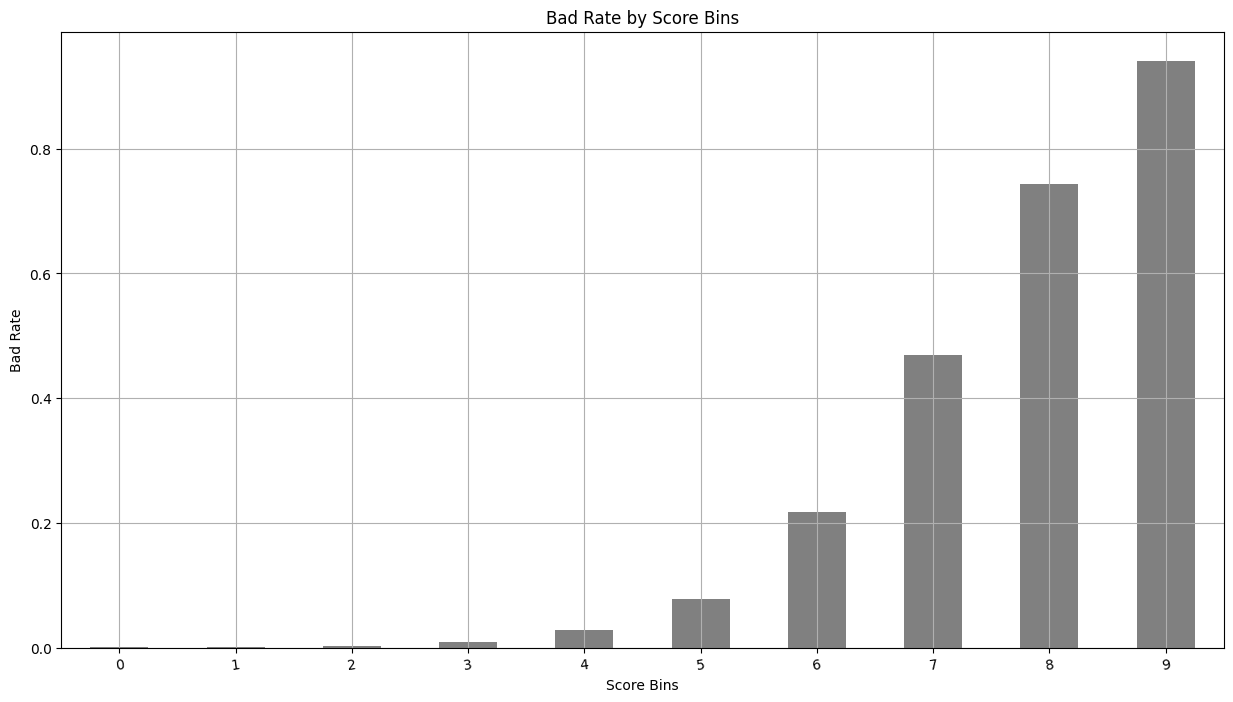

In [ ]:
plt.figure(figsize=(15, 8))
statistics['Bad Rate'].plot(kind='bar', color='grey')
plt.xlabel("Score Bins")
plt.xticks(rotation=8)
plt.ylabel('Bad Rate')
plt.title('Bad Rate by Score Bins')
plt.grid(True)
plt.show()

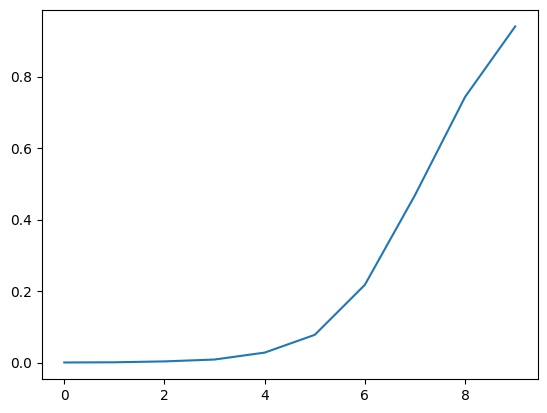

In [ ]:
plt.plot(statistics["Bad Rate"])  # statistics["Bad Rate"].plot()

#### Performance of XGB Model

In [ ]:
performance1 = pd.DataFrame({"Actual": y_test1, "Prediction": final_xgboost_model.predict_proba(X_test1)[:,1]})
performance1["Score Bins"] = pd.cut(performance1["Prediction"], quantiles)
statistics1 = performance1.groupby("Score Bins")["Actual"].agg(["sum", "count"])
statistics1["Bad Rate"] = statistics1["sum"] / statistics1["count"]
statistics1.reset_index(inplace=True)
statistics1.head(1)

,Score Bins,sum,count,Bad Rate
0,"(0.0, 0.00216]",3,3305,0.000908


In [ ]:
performance2 = pd.DataFrame({"Actual": y_test2, "Prediction": final_xgboost_model.predict_proba(X_test2)[:,1]})
performance2["Score Bins"] = pd.cut(performance2["Prediction"], quantiles)
statistics2 = performance2.groupby("Score Bins")["Actual"].agg(["sum", "count"])
statistics2["Bad Rate"] = statistics2["sum"] / statistics2["count"]
statistics2.reset_index(inplace=True)
statistics2.head(1)

,Score Bins,sum,count,Bad Rate
0,"(0.0, 0.00216]",2,3448,0.00058


In [ ]:
statistics.head(1)

,Score Bins,sum,count,Bad Rate
0,"(0.0, 0.00216]",4,15500,0.000258


In [ ]:
dfs = [statistics, statistics1, statistics2]
bad_scores = [df["Bad Rate"] for df in dfs]
combined_df = pd.concat(bad_scores, axis=1)
combined_df.index = statistics['Score Bins']
combined_df

,Bad Rate,Bad Rate,Bad Rate
Score Bins,,,
"(0.0, 0.00216]",0.000258,0.000908,0.000580
"(0.00216, 0.00429]",0.000774,0.001500,0.001497
"(0.00429, 0.00887]",0.003290,0.003662,0.005625
"(0.00887, 0.0205]",0.008517,0.013235,0.012467
"(0.0205, 0.0537]",0.027871,0.032452,0.031029
"(0.0537, 0.151]",0.077613,0.084498,0.079630
"(0.151, 0.357]",0.217562,0.231363,0.236644
"(0.357, 0.6]",0.468387,0.483304,0.477508
"(0.6, 0.807]",0.743290,0.733639,0.729813


/var/folders/s7/45zxppwj6wb8hl7_80_fr0cm0000gn/T/ipykernel_13046/2495444946.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(combined_df.index)


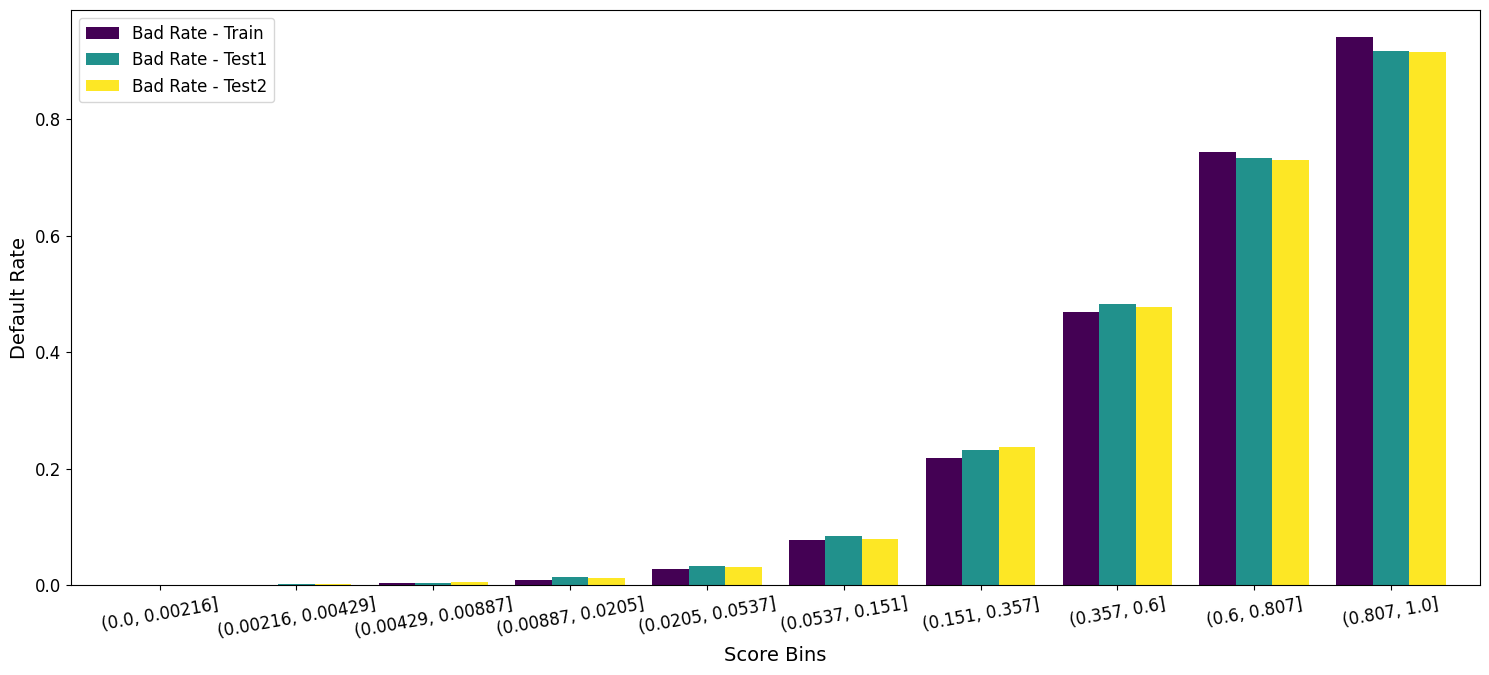

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_xticklabels(combined_df.index)
combined_df.plot(kind='bar', ax=ax, colormap='viridis', width=0.8)
plt.xlabel('Score Bins', fontsize=14)
plt.ylabel('Default Rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Bad Rate - Train', 'Bad Rate - Test1', 'Bad Rate - Test2'], fontsize=12)
plt.tight_layout()
plt.xticks(rotation=10)
plt.show()

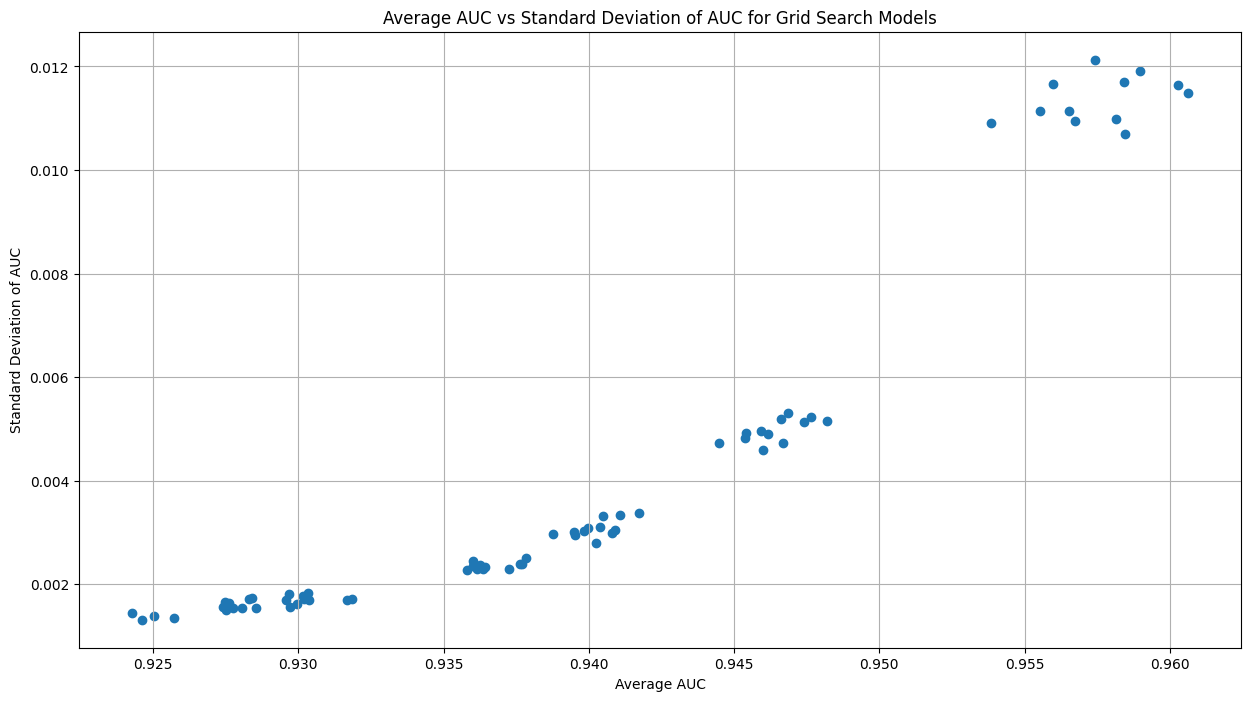

In [ ]:
# Average and standard deviation of AUCs
table['Average AUC'] = table[['AUC Train', 'AUC Test1', 'AUC Test2']].mean(axis=1)
table['Standard Deviation AUC'] = table[['AUC Train', 'AUC Test1', 'AUC Test2']].std(axis=1)

# Plot(s)
# Create scatter plot (Average AUC vs Standard Deviation of AUC for Grid Search Models)
plt.figure(figsize=(15, 8))
plt.scatter(table['Average AUC'], table['Standard Deviation AUC'])
plt.xlabel('Average AUC')
plt.ylabel('Standard Deviation of AUC')
plt.title('Average AUC vs Standard Deviation of AUC for Grid Search Models')
plt.grid(True)
plt.show()

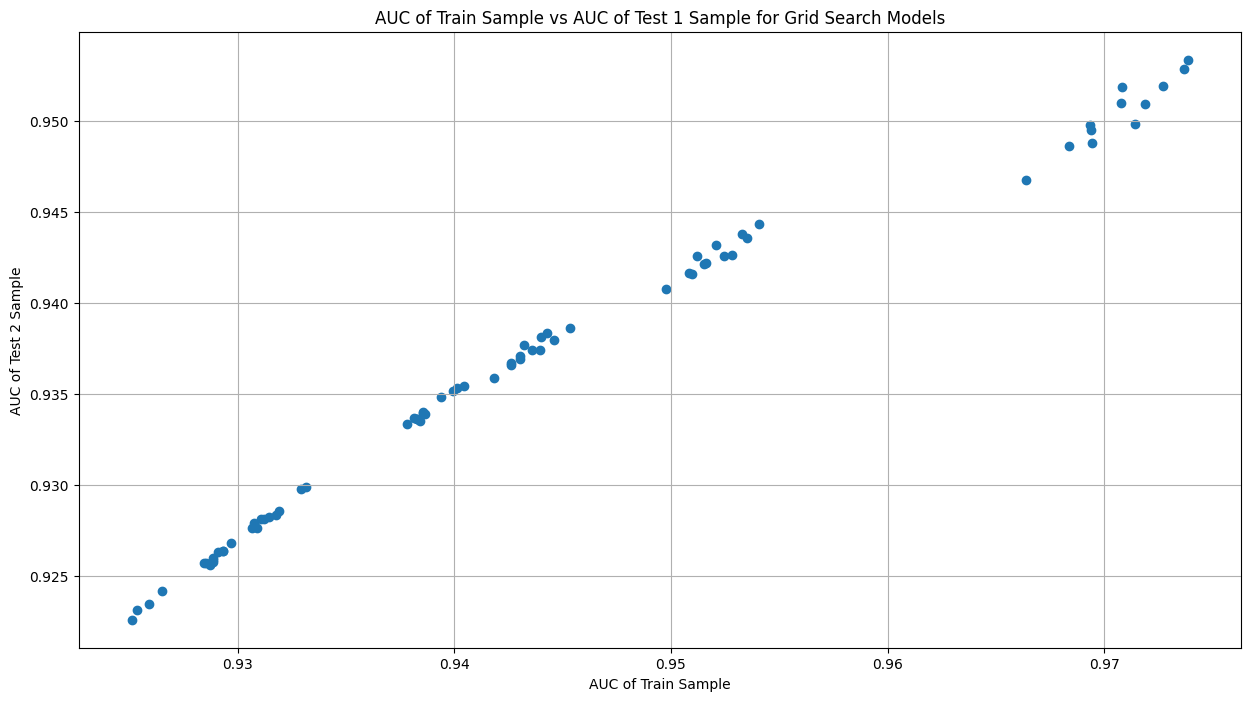

In [ ]:
# Create scatter plot (AUC of train sample vs AUC of Test 1 sample)
plt.figure(figsize=(15, 8))
plt.scatter(table['AUC Train'], table['AUC Test1'])
plt.xlabel('AUC of Train Sample')
plt.ylabel('AUC of Test 2 Sample')
plt.title('AUC of Train Sample vs AUC of Test 1 Sample for Grid Search Models')
plt.grid(True)
plt.show()

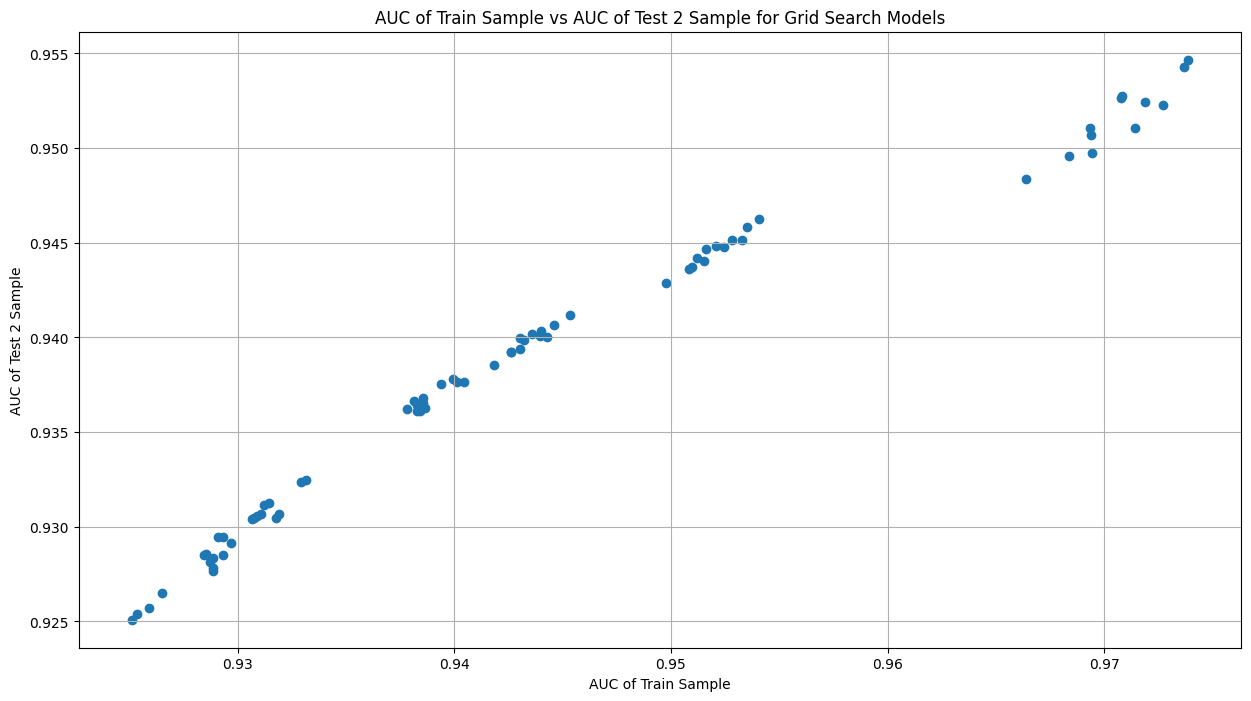

In [ ]:
# Create scatter plot (AUC of train sample vs AUC of Test 2 sample)
plt.figure(figsize=(15, 8))
plt.scatter(table['AUC Train'], table['AUC Test2'])
plt.xlabel('AUC of Train Sample')
plt.ylabel('AUC of Test 2 Sample')
plt.title('AUC of Train Sample vs AUC of Test 2 Sample for Grid Search Models')
plt.grid(True)
plt.show()

### SHAP

In [ ]:
import shap
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
explainer = shap.Explainer(final_xgboost_model)
calc_shap_values = explainer(X_test2)

[13:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[13:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


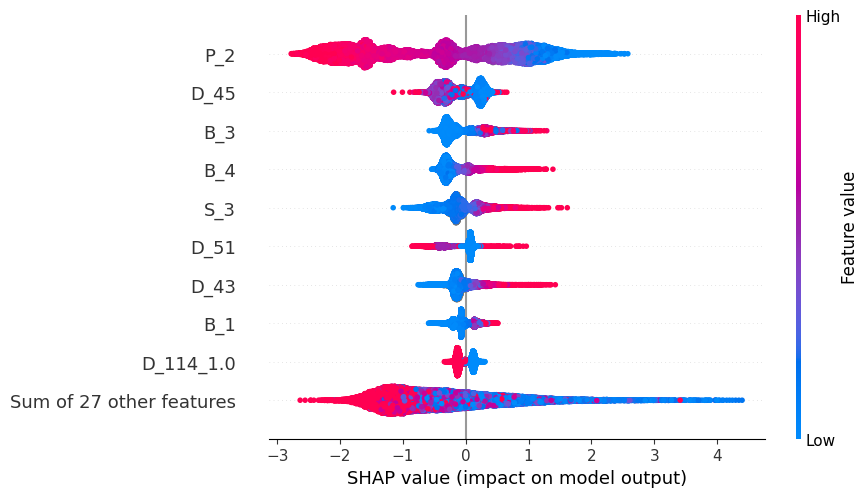

In [ ]:
shap.plots.beeswarm(calc_shap_values)

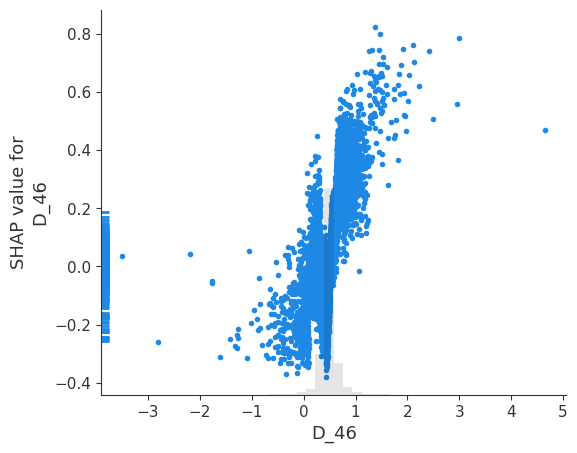

In [ ]:
shap.plots.scatter(calc_shap_values[:,"D_46"])

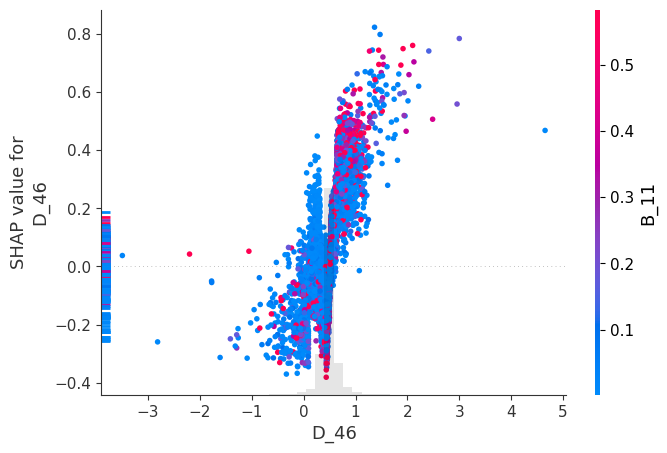

In [ ]:
shap.plots.scatter(calc_shap_values[:,"D_46"], color=calc_shap_values[:,"B_11"])

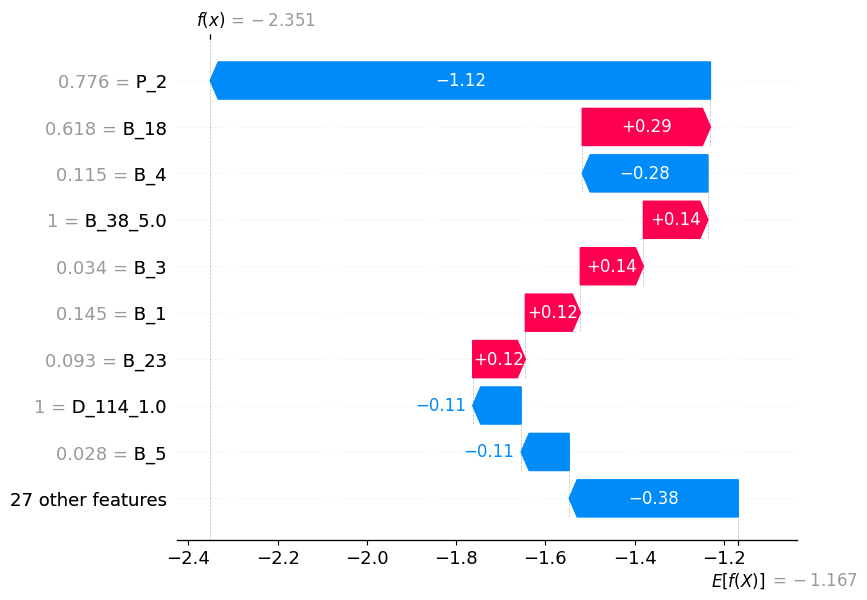

In [ ]:
shap.plots.waterfall(calc_shap_values[230])

#### 13. Neural Network preprocessing - outlier treatment and normalization

In [ ]:
# def remove_outliers_function(df, col_name):
#     Q1 = df[col_name].quantile(0.25)
#     Q3 = df[col_name].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
#     return df[(df[col_name] >= lower_bound) & (df[col_name] <= upper_bound)]
# filtered_X_train = X_train

# for col in filtered_X_train.columns:
#     filtered_X_train = remove_outliers_function(filtered_X_train, col)
# filtered_X_train

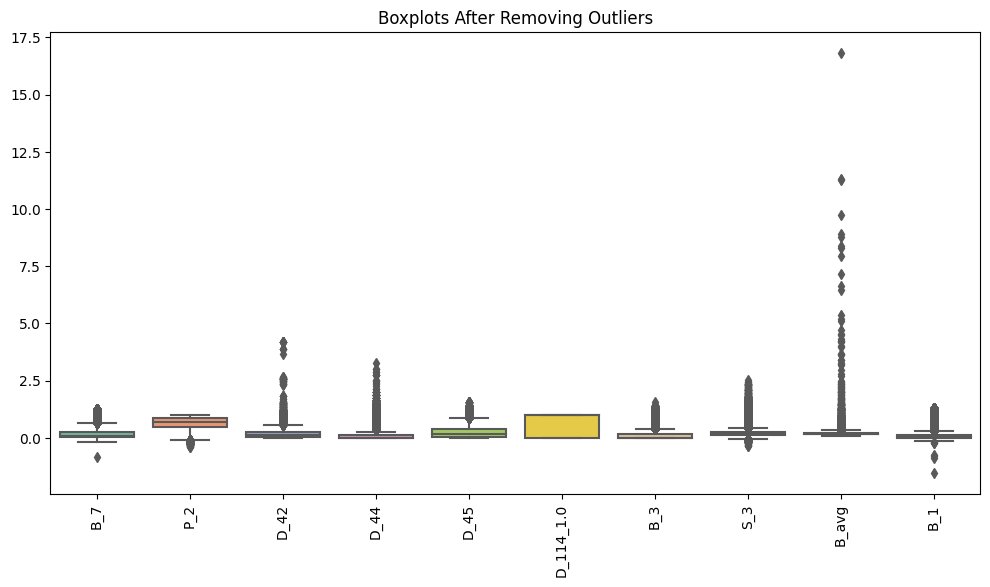

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train[X_train.columns[:10]], orient='v', palette='Set2')
plt.title('Boxplots After Removing Outliers')
plt.xticks(rotation=90)
plt.show()

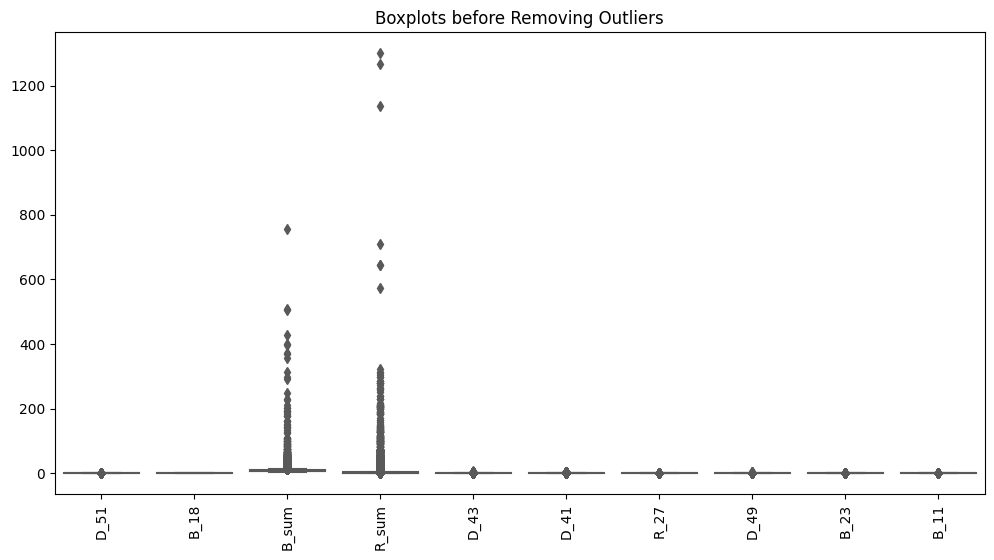

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train[X_train.columns[10:20]], orient='v', palette='Set2')
plt.title('Boxplots before Removing Outliers')
plt.xticks(rotation=90)
plt.show()

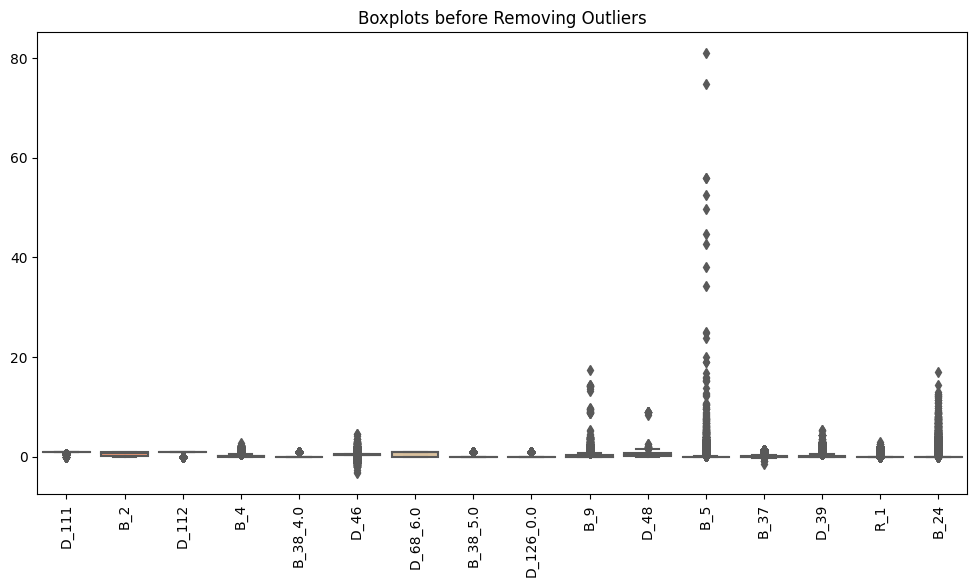

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train[X_train.columns[20:]], orient='v', palette='Set2')
plt.title('Boxplots before Removing Outliers')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Q1 = X_train.quantile(0.25)
# Q3 = X_train.quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# filtered_X_train = X_train[((X_train >= lower_bound) & (X_train <= upper_bound)).all(axis=1)]
# X_train

# ----

# def remove_outliers_function(df, col_name):
#     Q1 = df[col_name].quantile(0.25)
#     Q3 = df[col_name].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
#     return df[(df[col_name] >= lower_bound) & (df[col_name] <= upper_bound)]

# filtered_X_train = X_train.copy()

# append_df = pd.DataFrame()
# for col in X_train.columns:
#     # temp_df = remove_outliers_function(filtered_X_train, col)
#     # append_df = pd.concat([append_df, temp_df])
#     temp_df = remove_outliers_function(filtered_X_train, col)
#     append_df[col] = temp_df[col]

# temp_df.isna().sum()

In [ ]:
for column in X_train.columns:
  low_threshold = np.nanpercentile(X_train[column], 1)
  up_threshold = np.nanpercentile(X_train[column], 99)
  X_train[column] = np.where(X_train[column] < low_threshold, low_threshold,
                           np.where(X_train[column] > up_threshold, up_threshold, X_train[column]))
  X_train[column] = np.where(X_train[column] < low_threshold, low_threshold,
                           np.where(X_train[column] > up_threshold, up_threshold, X_train[column]))
  y_train = y_train.loc[X_train.index]

In [ ]:
# Q1 = X_test1.quantile(0.25)
# Q3 = X_test1.quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# filtered_X_test1 = X_test1[((X_test1 >= lower_bound) & (X_test1 <= upper_bound)).all(axis=1)]

In [ ]:
print(X_train.shape)
X_train.isna().sum()[X_train.isna().sum()>0]

(154998, 36)


P_2        1235
D_42     133056
D_44       7722
D_45         62
B_3          62
S_3       28631
D_43      45923
D_41         62
R_27       3685
D_49     140092
D_111    153993
B_2          62
D_112        81
D_46      33703
D_48      19876
B_37          1
dtype: int64

In [ ]:
X_train[X_train.isna().sum()[X_train.isna().sum()>0].index]

,P_2,D_42,D_44,D_45,B_3,S_3,D_43,D_41,R_27,D_49,D_111,B_2,D_112,D_46,D_48,B_37
106824,0.886425,NaN,0.007064,0.393199,0.009966,0.081775,0.009863,0.004016,1.000655,NaN,NaN,1.007544,1.007565,0.455978,0.042524,0.025500
55269,0.809433,NaN,0.006247,0.226432,0.000255,NaN,0.141937,0.004588,1.002459,NaN,NaN,0.818788,1.008132,0.453135,0.150057,0.001506
169935,0.892898,NaN,0.002665,0.309608,0.112104,0.136122,0.134323,0.003892,0.030223,NaN,NaN,1.000284,1.003371,NaN,0.025933,0.024631
165339,0.652000,NaN,0.006531,0.749067,0.045519,0.103334,0.006418,0.268892,1.004205,NaN,NaN,1.000033,0.007199,0.493289,0.294871,0.051007
124456,0.824064,NaN,0.001944,0.064782,0.161670,0.162107,0.035399,0.004869,1.000549,NaN,NaN,0.134879,1.005645,0.442552,0.198045,0.211482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.911869,NaN,0.003823,0.355851,0.022076,0.150913,NaN,0.009870,1.005205,NaN,NaN,0.813653,1.003149,0.415257,0.147337,0.028613
103694,0.786920,NaN,0.009773,0.039111,0.002741,0.170145,0.098138,0.004692,1.004312,NaN,NaN,1.005815,1.008336,NaN,NaN,0.004980
131932,0.120468,NaN,0.126328,0.493127,0.467129,0.710236,0.108464,0.005047,1.003581,NaN,NaN,0.076289,1.004970,0.463440,0.978173,0.269390
146867,0.540928,NaN,1.006124,0.247086,0.798098,0.705420,0.407509,0.003478,0.022276,0.113528,NaN,0.024334,1.001554,0.723269,0.732408,0.382493


In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test1_scaled = scaler.fit_transform(X_test1)
X_test2_scaled = scaler.fit_transform(X_test2)

In [ ]:
pd.DataFrame(X_train_scaled).isna().sum()

0          0
1       1235
2     133056
3       7722
4         62
5          0
6         62
7      28631
8          0
9          0
10         0
11         0
12         0
13         0
14     45923
15        62
16      3685
17    140092
18         0
19         0
20    153993
21        62
22        81
23         0
24         0
25     33703
26         0
27         0
28         0
29         0
30     19876
31         0
32         1
33         0
34         0
35         0
dtype: int64

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled).fillna(0).values

In [ ]:
X_test1_scaled = pd.DataFrame(X_test1_scaled).fillna(0).values
X_test2_scaled = pd.DataFrame(X_test2_scaled).fillna(0).values

#### 14. Neural Network using Grid Search

In [ ]:
def create_model(hidden_layers, num_nodes, activation_fn, dropout_rate):
    """
    create_model method creates a sequential classifier model with set no of hidden layers
    num_layers: [2, 4]
    num_nodes: [4, 6]
    activations: ['relu', 'tanh']
    dropout_rates: [0.5, 1.0]
    """
    classifier, optimizer = Sequential(), Adam()
    classifier.add(Dense(num_nodes, input_dim=X_train_scaled.shape[1], activation=activation_fn))

    for _ in range(0, hidden_layers - 1):
        classifier.add(Dense(num_nodes, activation=activation_fn))
        if dropout_rate < 1.0:
            classifier.add(Dropout(1-dropout_rate))

    classifier.add(Dense(units=1, activation='sigmoid'))
    classifier.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])
    return classifier

In [ ]:
# pd.DataFrame(X_train_scaled).isna().sum()[pd.DataFrame(X_train_scaled).isna().sum()>0]

In [ ]:
results = list()

# neural network grid-search parameters
num_layers, num_nodes, activations, dropout_rates  = [2, 4], [4, 6], ['relu', 'tanh'], [0.5, 1.0]
batch_sizes, epochs = [100, 10000], 20

for layers in num_layers:
    for nodes in num_nodes:
        for activation in activations:
            for dropout_rate in dropout_rates:
                for batch_size in batch_sizes:
                    model = create_model(layers, nodes, activation, dropout_rate)
                    history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

                    train_proba = model.predict(X_train_scaled).ravel()
                    train_auc = roc_auc_score(y_train, train_proba)  # compute AUC for train set

                    test1_proba = model.predict(X_test1_scaled).ravel()  # predict probabilities for test1
                    test1_auc = roc_auc_score(y_test1, test1_proba)  # compute AUC for test1

                    test2_proba = model.predict(X_test1_scaled).ravel()  # predict probabilities for test2
                    test2_auc = roc_auc_score(y_test2, test2_proba)   # compute AUC for test2

                    results.append({
                        'num_layers': layers, 'num_nodes': nodes,
                        'activation': activation, 'dropout_rate': dropout_rate,
                        'batch_size': batch_size, 'train_auc': train_auc,
                        'test1_auc': test1_auc, 'test2_auc': test2_auc
                        })

dataframe_results = pd.DataFrame(results)

1038/1038 [==============================] - 0s 226us/step


1038/1038 [==============================] - 0s 209us/step


1038/1038 [==============================] - 0s 209us/step


1038/1038 [==============================] - 0s 208us/step


1038/1038 [==============================] - 0s 209us/step


1038/1038 [==============================] - 0s 208us/step


1038/1038 [==============================] - 0s 206us/step


1038/1038 [==============================] - 0s 209us/step


1038/1038 [==============================] - 0s 209us/step


1038/1038 [==============================] - 0s 211us/step


1038/1038 [==============================] - 0s 209us/step


1038/1038 [==============================] - 0s 210us/step


1038/1038 [==============================] - 0s 211us/step


1038/1038 [==============================] - 0s 210us/step


1038/1038 [==============================] - 0s 210us/step


1038/1038 [==============================] - 0s 209us/step


1038/1038 [==============================] - 0s 214us/step


1038/1038 [==============================] - 0s 215us/step


1038/1038 [==============================] - 0s 213us/step


1038/1038 [==============================] - 0s 213us/step


1038/1038 [==============================] - 0s 211us/step


1038/1038 [==============================] - 0s 224us/step


1038/1038 [==============================] - 0s 217us/step


1038/1038 [==============================] - 0s 215us/step


1038/1038 [==============================] - 0s 214us/step


1038/1038 [==============================] - 0s 222us/step


1038/1038 [==============================] - 0s 214us/step


1038/1038 [==============================] - 0s 224us/step


1038/1038 [==============================] - 0s 219us/step


1038/1038 [==============================] - 0s 220us/step


1038/1038 [==============================] - 0s 218us/step


1038/1038 [==============================] - 0s 220us/step


In [ ]:
df_results = pd.DataFrame(results)
df_results

,num_layers,num_nodes,activation,dropout_rate,batch_size,train_auc,test1_auc,test2_auc
0,2,4,relu,0.5,100,0.927903,0.925949,0.500265
1,2,4,relu,0.5,10000,0.888920,0.886881,0.500051
2,2,4,relu,1.0,100,0.929424,0.927679,0.500576
3,2,4,relu,1.0,10000,0.891000,0.890146,0.501400
4,2,4,tanh,0.5,100,0.929250,0.927758,0.500459
5,2,4,tanh,0.5,10000,0.915253,0.913446,0.500695
6,2,4,tanh,1.0,100,0.929447,0.928307,0.500918
7,2,4,tanh,1.0,10000,0.914299,0.914722,0.502200
8,2,6,relu,0.5,100,0.930418,0.928509,0.500323
9,2,6,relu,0.5,10000,0.910472,0.909505,0.500592


In [ ]:
# From the above table we can see that the model at index 12 is the best performing
# model and also not that complex as there are only 2 hidden layers.
# num_layers	num_nodes	activation	dropout_rate	batch_size	train_auc	test1_auc	test2_au
# 2	               6	     tanh	       0.5	           100	      0.930243	0.927316	0.500765

In [ ]:
final_nn_model, optimizer = Sequential(), Adam()
final_nn_model.add(Dense(6, input_dim=X_train_scaled.shape[1], activation='relu'))
final_nn_model.add(Dense(1, activation='sigmoid'))
final_nn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])
final_nn_model.fit(X_train_scaled, y_train, epochs=20, batch_size=100, verbose=1)
final_nn_model.save('save_selected_model.h5')

Epoch 1/20
1550/1550 [==============================] - 1s 316us/step - loss: 0.3441 - auc: 0.9010
Epoch 2/20
1550/1550 [==============================] - 0s 316us/step - loss: 0.2954 - auc: 0.9248
Epoch 3/20
1550/1550 [==============================] - 0s 313us/step - loss: 0.2918 - auc: 0.9268
Epoch 4/20
1550/1550 [==============================] - 0s 314us/step - loss: 0.2901 - auc: 0.9277
Epoch 5/20
1550/1550 [==============================] - 0s 316us/step - loss: 0.2891 - auc: 0.9282
Epoch 6/20
1550/1550 [==============================] - 0s 316us/step - loss: 0.2881 - auc: 0.9287
Epoch 7/20
1550/1550 [==============================] - 0s 316us/step - loss: 0.2876 - auc: 0.9290
Epoch 8/20
1550/1550 [==============================] - 0s 314us/step - loss: 0.2871 - auc: 0.9293
Epoch 9/20
1550/1550 [==============================] - 0s 311us/step - loss: 0.2869 - auc: 0.9294
Epoch 10/20
1550/1550 [==============================] - 0s 312us/step - loss: 0.2865 - auc: 0.9296
Epoch 11/

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


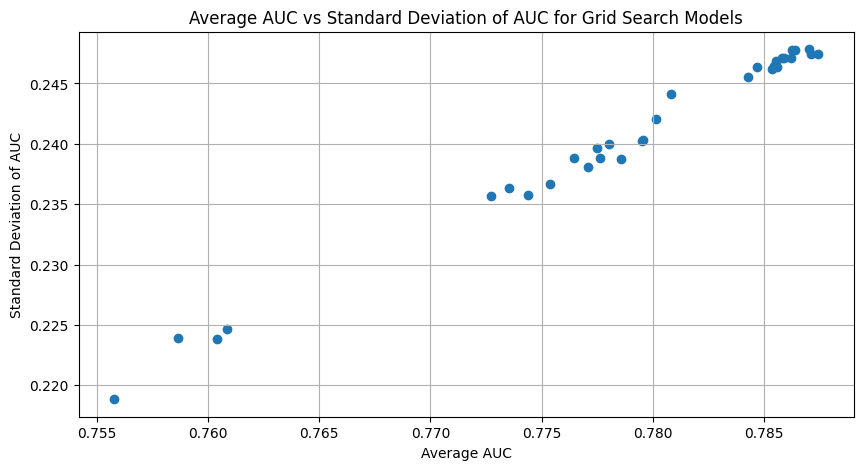

In [ ]:
df_results['Average AUC'] = df_results[['train_auc', 'test1_auc', 'test2_auc']].mean(axis=1)
df_results['Standard Deviation AUC'] = df_results[['train_auc', 'test1_auc', 'test2_auc']].std(axis=1)
plt.figure(figsize=(10, 5))
plt.scatter(df_results['Average AUC'], df_results['Standard Deviation AUC'])
plt.xlabel('Average AUC')
plt.ylabel('Standard Deviation of AUC')
plt.title('Average AUC vs Standard Deviation of AUC for Grid Search Models')
plt.grid(True)
plt.show()

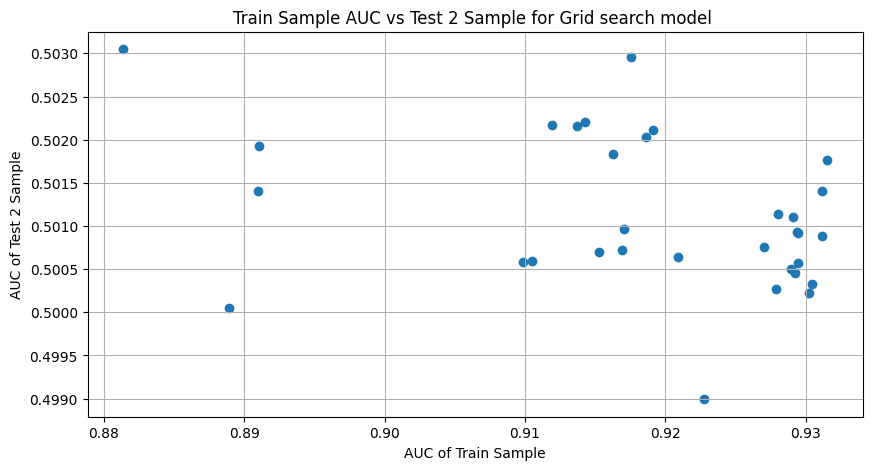

In [ ]:
# Create scatter plot (AUC of train sample vs AUC of Test 2 sample)
plt.figure(figsize=(10, 5))
plt.scatter(df_results['train_auc'], df_results['test2_auc'])
plt.xlabel('AUC of Train Sample')
plt.ylabel('AUC of Test 2 Sample')
plt.title('Train Sample AUC vs Test 2 Sample for Grid search model ')
plt.grid(True)
plt.show()

In [ ]:
y_pred = pd.DataFrame({"Actual": y_train,
                       "Prediction": [i[0] for i in final_nn_model.predict(X_train_scaled)]})
quantiles = list(set(y_pred.Prediction.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])))
quantiles.sort()
quantiles.insert(0,0)
quantiles.insert(len(quantiles),1)
y_pred["Score Bins"] = pd.cut(y_pred["Prediction"], quantiles)
statistics = y_pred.groupby("Score Bins")["Actual"].agg(["sum", "count"])
statistics["Bad Rate"] = statistics["sum"] / statistics["count"]
statistics.reset_index(inplace=True)
statistics

4844/4844 [==============================] - 1s 209us/step


,Score Bins,sum,count,Bad Rate
0,"(0.0, 0.00346]",36,15500,0.002323
1,"(0.00346, 0.00665]",44,15500,0.002839
2,"(0.00665, 0.0123]",97,15500,0.006258
3,"(0.0123, 0.0258]",277,15499,0.017872
4,"(0.0258, 0.0625]",563,15500,0.036323
5,"(0.0625, 0.163]",1593,15500,0.102774
6,"(0.163, 0.373]",3973,15499,0.256339
7,"(0.373, 0.614]",7592,15501,0.489775
8,"(0.614, 0.808]",10709,15499,0.690948
9,"(0.808, 1.0]",13679,15500,0.882516


In [ ]:
y_test1_pred = pd.DataFrame({"Actual": y_test1,
                             "Prediction": [i[0] for i in final_nn_model.predict(X_test1_scaled)]})
quantiles = list(set(y_test1_pred.Prediction.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])))
quantiles.sort()
quantiles.insert(0,0)
quantiles.insert(len(quantiles),1)
y_test1_pred["Score Bins"] = pd.cut(y_test1_pred["Prediction"], quantiles)
statistics1 = y_test1_pred.groupby("Score Bins")["Actual"].agg(["sum", "count"])
statistics1["Bad Rate"] = statistics1["sum"] / statistics1["count"]
statistics1.reset_index(inplace=True)
statistics1

1038/1038 [==============================] - 0s 239us/step


,Score Bins,sum,count,Bad Rate
0,"(0.0, 0.00376]",9,3322,0.002709
1,"(0.00376, 0.00706]",13,3321,0.003914
2,"(0.00706, 0.0128]",24,3321,0.007227
3,"(0.0128, 0.0266]",59,3322,0.017760
4,"(0.0266, 0.0632]",134,3321,0.040349
5,"(0.0632, 0.16]",326,3321,0.098163
6,"(0.16, 0.364]",882,3322,0.265503
7,"(0.364, 0.568]",1623,3321,0.488708
8,"(0.568, 0.757]",2302,3321,0.693165
9,"(0.757, 1.0]",2892,3322,0.870560


In [ ]:
y_test2_pred = pd.DataFrame({"Actual": y_test2,
                             "Prediction": [i[0] for i in final_nn_model.predict(X_test2_scaled)]})
quantiles = list(set(y_test2_pred.Prediction.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])))
quantiles.sort()
quantiles.insert(0,0)
quantiles.insert(len(quantiles),1)
y_test2_pred["Score Bins"] = pd.cut(y_test2_pred["Prediction"], quantiles)
statistics2 = y_test2_pred.groupby("Score Bins")["Actual"].agg(["sum", "count"])
statistics2["Bad Rate"] = statistics2["sum"] / statistics2["count"]
statistics2.reset_index(inplace=True)
statistics2

1038/1038 [==============================] - 0s 214us/step


,Score Bins,sum,count,Bad Rate
0,"(0.0, 0.00381]",6,3322,0.001806
1,"(0.00381, 0.00709]",16,3321,0.004818
2,"(0.00709, 0.0128]",25,3321,0.007528
3,"(0.0128, 0.0263]",54,3322,0.016255
4,"(0.0263, 0.0607]",105,3321,0.031617
5,"(0.0607, 0.156]",314,3321,0.094550
6,"(0.156, 0.357]",875,3322,0.263396
7,"(0.357, 0.57]",1610,3321,0.484794
8,"(0.57, 0.762]",2284,3321,0.687745
9,"(0.762, 1.0]",2913,3322,0.876881


FixedFormatter should only be used together with FixedLocator


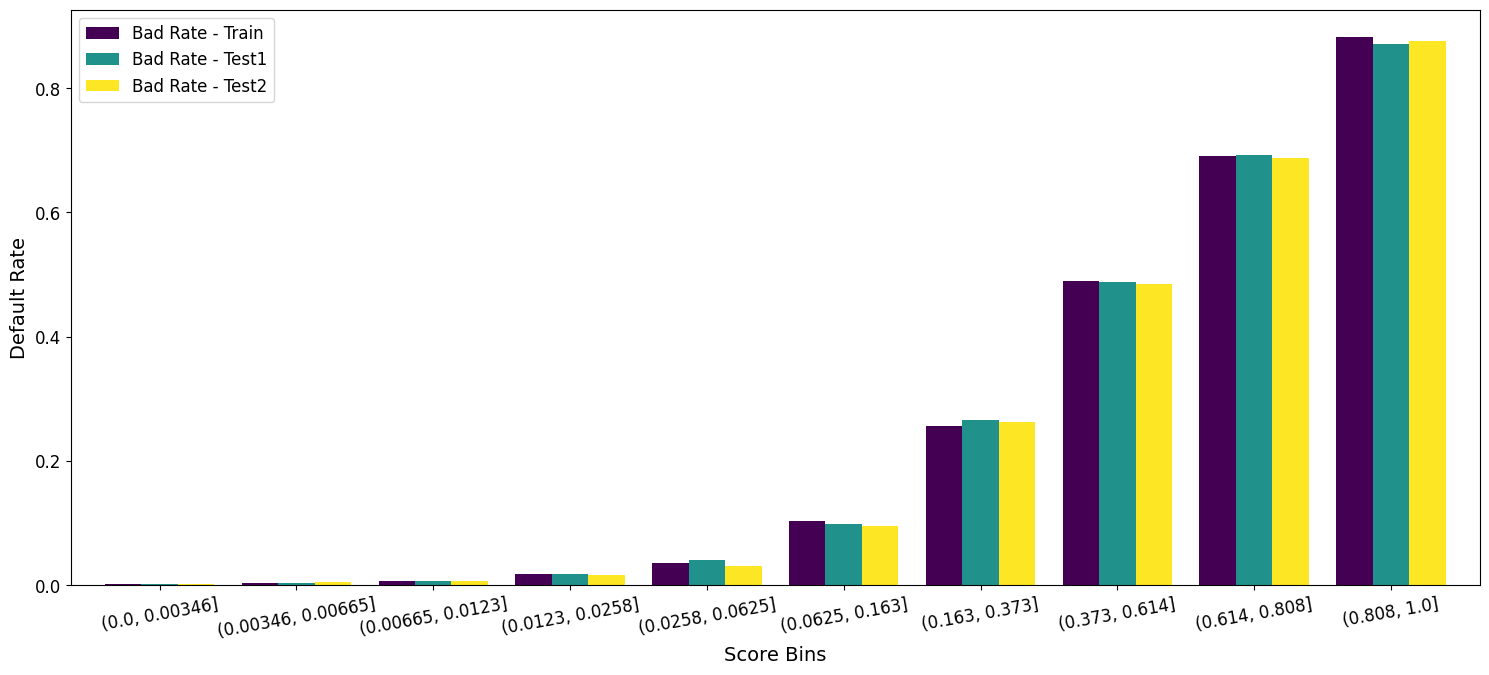

In [ ]:
dfs = [statistics, statistics1, statistics2]
bad_scores = [df["Bad Rate"] for df in dfs]
combined_df = pd.concat(bad_scores, axis=1)
combined_df.index = statistics['Score Bins']
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_xticklabels(combined_df.index)
combined_df.plot(kind='bar', ax=ax, colormap='viridis', width=0.8)
plt.xlabel('Score Bins', fontsize=14)
plt.ylabel('Default Rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Bad Rate - Train', 'Bad Rate - Test1', 'Bad Rate - Test2'], fontsize=12)
plt.tight_layout()
plt.xticks(rotation=10)
plt.show()

In [ ]:
# def estimate_portfolio(df, target, output, balance_col, spend_col, threshold):
#     df['accept'] = (df[output] < threshold).astype(int)
#     df['revenue'] = (df[balance_co1]*0.02 + df['spend_col']*0.001) * 12
#     df_accepted = df[df['accept']==1]
#     exp_default_rate = df_accepted[target].sum() / df_accepted.shape[0]
#     exp_revenue = (df_accepted.groupby(target).sum()[['revenue']])['revenue'][0]
#     return exp_default_rate, exp_revenue, df_accepted. shape[0]

In [ ]:
def calculate_metrics(df, threshold):
    accepted_customers = df[df["predicted_default"] < threshold].copy()
    portfolio_default_rate = accepted_customers['target'].mean()
    accepted_customers["Monthly_Revenue"] = accepted_customers["B_1"]*0.02 + accepted_customers["S_3"]*0.001
    portfolio_expected_revenue = (accepted_customers[accepted_customers["target"] == 0]["Monthly_Revenue"] * 12).sum()
    return portfolio_default_rate, portfolio_expected_revenue

In [ ]:
X3_test2 = X_train[final_features]
predicted_default_test2 = final_xgboost_model.predict_proba(X3_test2)[:, 1]
X3_test2['predicted_default'] = predicted_default_test2
df["predicted_default"] = final_xgboost_model.predict_proba(df[final_features])[:, 1]
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.575, 0.585, 0.6,0.7,0.8,0.9]:
    print(f"Threshold: {threshold}")
    default_rate, expected_revenue = calculate_metrics(df, threshold)
    print(f"Default Rate: {default_rate}, Expected Revenue: {expected_revenue}")

Threshold: 0.1
Default Rate: 0.014421255431146364, Expected Revenue: 1071.4249268120134
Threshold: 0.2
Default Rate: 0.02652358050391214, Expected Revenue: 1481.4398623878346
Threshold: 0.3
Default Rate: 0.040304974529819806, Expected Revenue: 1845.3273784579947
Threshold: 0.4
Default Rate: 0.05661659671136674, Expected Revenue: 2186.5838983457284
Threshold: 0.5
Default Rate: 0.07645017411630015, Expected Revenue: 2475.4819639443886
Threshold: 0.55
Default Rate: 0.0886901240153598, Expected Revenue: 2608.275036555504
Threshold: 0.575
Default Rate: 0.09538760687426726, Expected Revenue: 2671.171689034975
Threshold: 0.585
Default Rate: 0.09809374324677836, Expected Revenue: 2696.5935160761455
Threshold: 0.6
Default Rate: 0.10215441881450567, Expected Revenue: 2733.9279651263855
Threshold: 0.7
Default Rate: 0.13313701012558282, Expected Revenue: 2932.859473112091
Threshold: 0.8
Default Rate: 0.16973251308715873, Expected Revenue: 3077.399731933102
Threshold: 0.9
Default Rate: 0.2105690863

In [ ]:
X3_test2 = X_test1[final_features]
predicted_default_test2 = final_xgboost_model.predict_proba(X3_test2)[:, 1]
X3_test2['predicted_default'] = predicted_default_test2
df["predicted_default"] = final_xgboost_model.predict_proba(df[final_features])[:, 1]
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.575, 0.585, 0.6,0.7,0.8,0.9]:
    print(f"Threshold: {threshold}")
    default_rate, expected_revenue = calculate_metrics(df, threshold)
    print(f"Default Rate: {default_rate}, Expected Revenue: {expected_revenue}")

Threshold: 0.1
Default Rate: 0.014421255431146364, Expected Revenue: 1071.4249268120134
Threshold: 0.2
Default Rate: 0.02652358050391214, Expected Revenue: 1481.4398623878346
Threshold: 0.3
Default Rate: 0.040304974529819806, Expected Revenue: 1845.3273784579947
Threshold: 0.4
Default Rate: 0.05661659671136674, Expected Revenue: 2186.5838983457284
Threshold: 0.5
Default Rate: 0.07645017411630015, Expected Revenue: 2475.4819639443886
Threshold: 0.55
Default Rate: 0.0886901240153598, Expected Revenue: 2608.275036555504
Threshold: 0.575
Default Rate: 0.09538760687426726, Expected Revenue: 2671.171689034975
Threshold: 0.585
Default Rate: 0.09809374324677836, Expected Revenue: 2696.5935160761455
Threshold: 0.6
Default Rate: 0.10215441881450567, Expected Revenue: 2733.9279651263855
Threshold: 0.7
Default Rate: 0.13313701012558282, Expected Revenue: 2932.859473112091
Threshold: 0.8
Default Rate: 0.16973251308715873, Expected Revenue: 3077.399731933102
Threshold: 0.9
Default Rate: 0.2105690863

In [ ]:
X3_test2 = X_test2[final_features]
predicted_default_test2 = final_xgboost_model.predict_proba(X3_test2)[:, 1]
X3_test2['predicted_default'] = predicted_default_test2
df["predicted_default"] = final_xgboost_model.predict_proba(df[final_features])[:, 1]
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.575, 0.585, 0.6,0.7,0.8,0.9]:
    print(f"Threshold: {threshold}")
    default_rate, expected_revenue = calculate_metrics(df, threshold)
    print(f"Default Rate: {default_rate}, Expected Revenue: {expected_revenue}")

Threshold: 0.1
Default Rate: 0.014421255431146364, Expected Revenue: 1071.4249268120134
Threshold: 0.2
Default Rate: 0.02652358050391214, Expected Revenue: 1481.4398623878346
Threshold: 0.3
Default Rate: 0.040304974529819806, Expected Revenue: 1845.3273784579947
Threshold: 0.4
Default Rate: 0.05661659671136674, Expected Revenue: 2186.5838983457284
Threshold: 0.5
Default Rate: 0.07645017411630015, Expected Revenue: 2475.4819639443886
Threshold: 0.55
Default Rate: 0.0886901240153598, Expected Revenue: 2608.275036555504
Threshold: 0.575
Default Rate: 0.09538760687426726, Expected Revenue: 2671.171689034975
Threshold: 0.585
Default Rate: 0.09809374324677836, Expected Revenue: 2696.5935160761455
Threshold: 0.6
Default Rate: 0.10215441881450567, Expected Revenue: 2733.9279651263855
Threshold: 0.7
Default Rate: 0.13313701012558282, Expected Revenue: 2932.859473112091
Threshold: 0.8
Default Rate: 0.16973251308715873, Expected Revenue: 3077.399731933102
Threshold: 0.9
Default Rate: 0.2105690863